<a href="https://colab.research.google.com/github/mcheung2016/newrepo/blob/master/GroupProject_CHAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIS 545 Group Project
### Does an increase in global temperatures correlate with an increase in the frequency of natural disasters?

**Team Members: Max Cheung, Usman Raja, Donald Hughes**

The goal of this project is to explore the relationship between increasing global temperatures and the frequency of natural disasters.

# **0.** Libraries and Setup
Run the following to setup the notebook.

In [ ]:
# upgrade to Pandas 2 (may have to revert to 1.4.4)
!python -m pip install --upgrade pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 20.4 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas~=1.5.3, but you have pandas 2.0.1 which is incompatible.


In [ ]:
# Sklearn and Pandas Setup
import json
import glob
import pandas as pd
import numpy as np
import datetime as dt
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from google.colab import drive
from sklearn.model_selection import train_test_split

# **1.** ETL (Extract, Load, & Transform)

## **1.1.** Extract from sources and load into dataframes

### **1.1.1.** Setup Kaggle integration

Load CSV from a Kaggle dataset.

To get the data in here:
1. Create a Kaggle account (unless you already have an account)
2. Go to Account and click on "Create New API Token" to get the API key in the form of a json file `kaggle.json`
3. Upload the `kaggle.json` file to the default location in your Google Drive.


In [ ]:
# Run this cell to mount your drive (you will be prompted to sign in)
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Create the kaggle directory and read the uploaded kaggle.json file
# (NOTE: Do NOT run this cell more than once unless restarting kernel)
!mkdir ~/.kaggle

In [ ]:
# Read the uploaded kaggle.json file
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/

### **1.1.2.** Load temperature time-series data

#### **1.1.2.1.** Berkeley Earth surface temperatures

The primary source of temperature data is from the [Berkeley Earth Surface Temperature Study](https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data).  The data is provided in several files to cover viewing the data by city, major city, country, and state/province.


In [ ]:
# Download dataset
!!kaggle datasets download -d berkeleyearth/climate-change-earth-surface-temperature-data

['Downloading climate-change-earth-surface-temperature-data.zip to /content',
 '',
 '  0% 0.00/84.7M [00:00<?, ?B/s]',
 '  6% 5.00M/84.7M [00:00<00:02, 35.6MB/s]',
 ' 21% 18.0M/84.7M [00:00<00:00, 84.3MB/s]',
 ' 39% 33.0M/84.7M [00:00<00:00, 80.1MB/s]',
 ' 58% 49.0M/84.7M [00:00<00:00, 79.1MB/s]',
 ' 70% 59.0M/84.7M [00:00<00:00, 85.1MB/s]',
 ' 85% 72.0M/84.7M [00:00<00:00, 98.0MB/s]',
 '',
 '100% 84.7M/84.7M [00:00<00:00, 94.6MB/s]']

In [ ]:
# Unzip folder in Colab content folder
!unzip -o /content/climate-change-earth-surface-temperature-data.zip

Archive:  /content/climate-change-earth-surface-temperature-data.zip
  inflating: GlobalLandTemperaturesByCity.csv  
  inflating: GlobalLandTemperaturesByCountry.csv  
  inflating: GlobalLandTemperaturesByMajorCity.csv  
  inflating: GlobalLandTemperaturesByState.csv  
  inflating: GlobalTemperatures.csv  


In [ ]:
# read the data files into dataframes

# glt_cities = pd.read_csv('GlobalLandTemperaturesByCity.csv')
temp_major_cities = pd.read_csv('GlobalLandTemperaturesByMajorCity.csv')
temp_states = pd.read_csv('GlobalLandTemperaturesByState.csv')
temp_countries = pd.read_csv('GlobalLandTemperaturesByCountry.csv')
temp_global = pd.read_csv('GlobalTemperatures.csv')

In [ ]:
temp_major_cities.head(5)

dt  AverageTemperature  AverageTemperatureUncertainty     City   
0  1849-01-01              26.704                          1.435  Abidjan  \
1  1849-02-01              27.434                          1.362  Abidjan   
2  1849-03-01              28.101                          1.612  Abidjan   
3  1849-04-01              26.140                          1.387  Abidjan   
4  1849-05-01              25.427                          1.200  Abidjan   

         Country Latitude Longitude  
0  Côte D'Ivoire    5.63N     3.23W  
1  Côte D'Ivoire    5.63N     3.23W  
2  Côte D'Ivoire    5.63N     3.23W  
3  Côte D'Ivoire    5.63N     3.23W  
4  Côte D'Ivoire    5.63N     3.23W

### **1.1.3.** Load disaster data

We look to a variety of sources to find disaster data that is the most comprehensive.

#### **1.1.3.1.** Natural disasters from Our World in Data

In [ ]:
!!kaggle datasets download -d brsdincer/all-natural-disasters-19002021-eosdis

['Downloading all-natural-disasters-19002021-eosdis.zip to /content',
 '',
 '  0% 0.00/2.31M [00:00<?, ?B/s]',
 '',
 '100% 2.31M/2.31M [00:00<00:00, 118MB/s]']

In [ ]:
!unzip -o /content/all-natural-disasters-19002021-eosdis.zip

Archive:  /content/all-natural-disasters-19002021-eosdis.zip
  inflating: DISASTERS/1900_2021_DISASTERS.xlsx - emdat data.csv  
  inflating: DISASTERS/1970-2021_DISASTERS.xlsx - emdat data.csv  


In [ ]:
disasters = pd.read_csv('/content/DISASTERS/1900_2021_DISASTERS.xlsx - emdat data.csv')

#### **1.1.3.2.** Natural disasters from US declarations

In [ ]:
!!kaggle datasets download -d headsortails/us-natural-disaster-declarations

['Downloading us-natural-disaster-declarations.zip to /content',
 '',
 '  0% 0.00/3.95M [00:00<?, ?B/s]',
 '',
 '100% 3.95M/3.95M [00:00<00:00, 76.0MB/s]']

In [ ]:
!unzip -o /content/us-natural-disaster-declarations.zip

Archive:  /content/us-natural-disaster-declarations.zip
  inflating: us_disaster_declarations.csv  
  inflating: us_disasters_m5.csv     


In [ ]:
disaster_us_declarations = pd.read_csv('us_disaster_declarations.csv')

#### **1.1.3.3.** Natural disasters from NOAA

We pulled in natural disaster data from NOAA, covering Tsunamis, Earthquakes, and Volcanoes.

In [ ]:
import json
import requests

# www.ngdc.noaa.gov/hazel/hazard-service/api/v1/tsunamis/events?minYear=1900&maxYear=2022
# www.ngdc.noaa.gov/hazel/hazard-service/api/v1/earthquakes?minYear=1900&maxYear=2022
resp = requests.get('https://www.ngdc.noaa.gov/hazel/hazard-service/api/v1/tsunamis/events?minYear=1950&maxYear=2022')
data = json.loads(resp.text)
disaster_tsunamis = pd.json_normalize(data, record_path =['items'] )

resp = requests.get('https://www.ngdc.noaa.gov/hazel/hazard-service/api/v1/earthquakes?minYear=1950&maxYear=2022')
data = json.loads(resp.text)
disaster_earthquakes = pd.json_normalize(data, record_path =['items'] )

resp = requests.get('https://www.ngdc.noaa.gov/hazel/hazard-service/api/v1/volcanoes?minYear=1950&maxYear=2022')
data = json.loads(resp.text)
disaster_volcanoes = pd.json_normalize(data, record_path =['items'] )

#### **1.1.3.4.** Load geocoded disaster data

Data sourced from:
Rosvold, E., and H. Buhaug. 2021. Geocoded Disasters (GDIS) Dataset. Palisades, New York: NASA Socioeconomic Data and Applications Center (SEDAC). https://doi.org/10.7927/zz3b-8y61.  

This data set consists of 39,953 locations for 9,924 disasters that occurred worldwide for the years 1960 to 2018 and is available in Geodatabase (.gdb), GeoPackage (.gpkg), CSV, and R-Workspace (.rdata) formats, along with the R-script source code (.r) and a Codebook (.pdf).

Stored in Google Drive for access.
https://drive.google.com/file/d/1yBQLELuIMy824aocxXE9TCrXmEzcpa2K/view?usp=share_link



In [ ]:
!!kaggle datasets download -d shaimaa1234/space-for-changenasa

['Downloading space-for-changenasa.zip to /content',
 '',
 '  0% 0.00/979k [00:00<?, ?B/s]',
 '',
 '100% 979k/979k [00:00<00:00, 30.5MB/s]']

In [ ]:
!unzip -o /content/space-for-changenasa.zip

Archive:  /content/space-for-changenasa.zip
  inflating: pend-gdis-1960-2018-disasterlocations.csv  


In [ ]:
geo_disasters = pd.read_csv('pend-gdis-1960-2018-disasterlocations.csv')
geo_disasters.head(15)

id     country iso3   gwno  year  geo_id  geolocation  level        adm1   
0   109     Albania  ALB  339.0  2009     346  Ana E Malit      3     Shkoder  \
1   109     Albania  ALB  339.0  2009     351       Bushat      3     Shkoder   
2   175      Angola  AGO  540.0  2001     760       Onjiva      3      Cunene   
3   187      Angola  AGO  540.0  2009     710        Evale      3      Cunene   
4   187      Angola  AGO  540.0  2009     749         Mupa      3      Cunene   
5   187      Angola  AGO  540.0  2009     761       Onjiva      3      Cunene   
6   189      Angola  AGO  540.0  2010     711        Evale      3      Cunene   
7   189      Angola  AGO  540.0  2010     750         Mupa      3      Cunene   
8   527  Bangladesh  BGD  771.0  1995    1875       Hatiya      3  Chittagong   
9   533  Bangladesh  BGD  771.0  1996    1865      Ghatail      3       Dhaka   
10  533  Bangladesh  BGD  771.0  1996    1872     Gopalpur      3       Dhaka   
11  533  Bangladesh  BGD  771.0  1996    1916     Kalihati      3       Dhaka   
12  533  Bangladesh  BGD  771.0  1996    2004     Mirzapur      3       Dhaka   
13  533  Bangladesh  BGD  771.0  1996    2194  Sarishabari      3       Dhaka   
14  539  Bangladesh  BGD  771.0  1997    1989  Maheshkhali      3  Chittagong   

           adm2         adm3     location  historical hist_country   
0      Shkodres  Ana E Malit  Ana E Malit           0          NaN  \
1      Shkodres       Bushat       Bushat           0          NaN   
2      Cuanhama       Onjiva       Onjiva           0          NaN   
3      Cuanhama        Evale        Evale           0          NaN   
4       Cuvelai         Mupa         Mupa           0          NaN   
5      Cuanhama       Onjiva       Onjiva           0          NaN   
6      Cuanhama        Evale        Evale           0          NaN   
7       Cuvelai         Mupa         Mupa           0          NaN   
8      Noakhali       Hatiya       Hatiya           0          NaN   
9       Tangail      Ghatail      Ghatail           0          NaN   
10      Tangail     Gopalpur     Gopalpur           0          NaN   
11      Tangail     Kalihati     Kalihati           0          NaN   
12      Tangail     Mirzapur     Mirzapur           0          NaN   
13     Jamalpur  Sarishabari  Sarishabari           0          NaN   
14  Cox'S Bazar  Maheshkhali   Moheshkali           0          NaN   

   disastertype disasterno   latitude  longitude  
0         flood  2009-0631  42.020948  19.418317  
1         flood  2009-0631  41.959294  19.514309  
2         flood  2001-0146 -17.093484  15.665758  
3         flood  2009-0092 -16.531533  15.773987  
4         flood  2009-0092 -16.200065  15.844189  
5         flood  2009-0092 -17.093484  15.665758  
6         flood  2010-0105 -16.531533  15.773987  
7         flood  2010-0105 -16.200065  15.844189  
8         storm  1995-0082  22.291591  91.065456  
9         storm  1996-0086  24.467312  90.052856  
10        storm  1996-0086  24.574008  89.901174  
11        storm  1996-0086  24.352354  89.941713  
12        storm  1996-0086  24.113306  90.106433  
13        storm  1996-0086  24.718921  89.836541  
14        storm  1997-0114  21.615555  91.922088

### **1.1.4.** Load additional geographical data

To augment our temperature data, we also pulled in precipitation and elevation data.  

#### **1.1.4.1.** World cities

Pull in a list of all [cities around the world](https://www.kaggle.com/datasets/juanmah/world-cities?select=worldcities.csv) to serve as a foundation for city-by-city analysis.

In [ ]:
!!kaggle datasets download -d juanmah/world-cities

['Downloading world-cities.zip to /content',
 '',
 '  0% 0.00/1.56M [00:00<?, ?B/s]',
 '',
 '100% 1.56M/1.56M [00:00<00:00, 72.2MB/s]']

In [ ]:
!unzip -o /content/world-cities.zip

Archive:  /content/world-cities.zip
  inflating: worldcities.csv         


In [ ]:
cities = pd.read_csv('worldcities.csv')

#### **1.1.4.2.** Precipitation by city

This dataset pulls in the [Wikipedia climate tables](https://www.kaggle.com/datasets/brankokokanovic/wiki-climate) for cities around the world with populations > 10,000.  While the temperature data itself is not particurly additive to the Berkeley Earth data, it does add Precipitation.

In [ ]:
!!kaggle datasets download -d brankokokanovic/wiki-climate

['Downloading wiki-climate.zip to /content',
 '',
 '  0% 0.00/2.48M [00:00<?, ?B/s]',
 '',
 '100% 2.48M/2.48M [00:00<00:00, 71.8MB/s]']

In [ ]:
!unzip -o /content/wiki-climate.zip

Archive:  /content/wiki-climate.zip
  inflating: wiki-climate.json       


In [ ]:
wiki_climate = pd.read_json('wiki-climate.json')
wiki_climate.head(5)

location  Jan record high C   
0                       Delhi (Safdarjung) 1971–1990               30.0  \
1  Shanghai (normals 1981–2010, extremes 1951–pre...               22.1   
2  Beijing (normals 1971–2000, extremes 1951–pres...               14.3   
3  Lagos ([[Murtala Muhammed International Airpor...               40.0   
4                                            Karachi               32.8   

   Feb record high C  Mar record high C  Apr record high C  May record high C   
0               34.1               40.6               45.6               47.2  \
1               27.0               29.6               34.3               36.4   
2               19.8               29.5               33.5               41.1   
3               37.1               37.0               39.6               37.0   
4               36.1               41.5               44.4               47.8   

   Jun record high C  Jul record high C  Aug record high C  Sep record high C   
0               46.7               45.0               42.0               40.6  \
1               37.5               39.2               39.9               38.2   
2               40.6               41.9               38.3               35.0   
3               37.6               33.2               33.0               33.2   
4               47.0               42.2               41.7               42.8   

   ...  Apr snowfall mm  May snowfall mm  Jun snowfall mm Jul snowfall mm   
0  ...              NaN              NaN              NaN             NaN  \
1  ...              NaN              NaN              NaN             NaN   
2  ...              NaN              NaN              NaN             NaN   
3  ...              NaN              NaN              NaN             NaN   
4  ...              NaN              NaN              NaN             NaN   

   Aug snowfall mm  Sep snowfall mm  Oct snowfall mm  Nov snowfall mm   
0              NaN              NaN              NaN              NaN  \
1              NaN              NaN              NaN              NaN   
2              NaN              NaN              NaN              NaN   
3              NaN              NaN              NaN              NaN   
4              NaN              NaN              NaN              NaN   

   Dec snowfall mm  year normal C  
0              NaN            NaN  
1              NaN            NaN  
2              NaN            NaN  
3              NaN            NaN  
4              NaN            NaN  

[5 rows x 354 columns]

#### **1.1.4.3.** Elevation by city

In [ ]:
resp = requests.get('https://storage.googleapis.com/kaggle-forum-message-attachments/285920/8617/CitiesEnriched.csv')
open('CitiesEnriched.csv', 'wb').write(resp.content)

35737

In [ ]:
cities_enriched = pd.read_csv('CitiesEnriched.csv')

#### **1.1.4.4** Country coordinates

The country coordinates are loaded to allow us to classify a country by it's hemisphere: northern, sourthern, or tropical.

In [ ]:
!!kaggle datasets download -d vinitasilaparasetty/country-coordinates-world

['Downloading country-coordinates-world.zip to /content',
 '',
 '  0% 0.00/4.63k [00:00<?, ?B/s]',
 '',
 '100% 4.63k/4.63k [00:00<00:00, 8.99MB/s]']

In [ ]:
!unzip -o /content/country-coordinates-world.zip

Archive:  /content/country-coordinates-world.zip
  inflating: country-coordinates-world.csv  


In [ ]:
country_coords = pd.read_csv('/content/country-coordinates-world.csv')

## **1.2.** Transform/combine data

### **1.2.1** Combine geographical data into one dataframe for cities

Combine cities_enriched, wiki_climate, and cities into one dataframe called 'world_cities'.  Primary goal is to add 'elevation' and 'precipitation' data to the dataframe.

Matching on city names is not precise enough, so we use latitude and longitude, rounded to two decimal places (1.1 miles).

Other data like 'country', 'capital', 'population', and 'timezone' may be useful for analysis, as well.

In [ ]:
# Match on Lat/Lng (tenths: 11 miles, hundredths: 1.1 miles)

# Add rounded lat/lon columns
cities_enriched.loc[:, 'rlat'] = cities_enriched['Lat'].round(1)
cities_enriched.loc[:, 'rlon'] = cities_enriched['Lng'].round(1)

wiki_climate.loc[:, 'rlat'] = wiki_climate['gps_lat'].round(1)
wiki_climate.loc[:, 'rlon'] = wiki_climate['gps_lon'].round(1)

cities.loc[:, 'rlat'] = cities['lat'].round(1)
cities.loc[:, 'rlon'] = cities['lng'].round(1)

In [ ]:

#world_cities = cities.merge(cities_enriched, left_on=['rlat','rlon'], right_on=['rlat','rlon'])
world_cities = cities.merge(wiki_climate, left_on=['rlat','rlon'], right_on=['rlat','rlon'])

In [ ]:
# remove unnecessary columns
world_cities = world_cities[[
    'city', 'city_ascii', 'lat', 'lng', 'country_x', 'iso2', 'admin_name',
    'population_x', 'rlat', 'rlon', "Jan precipitation mm", "Feb precipitation mm",
		"Mar precipitation mm", "Apr precipitation mm", "May precipitation mm",
		"Jun precipitation mm", "Jul precipitation mm", "Aug precipitation mm",
		"Sep precipitation mm", "Oct precipitation mm", "Nov precipitation mm",
		"Dec precipitation mm", "year precipitation mm", "Jan precipitation days",
		"Feb precipitation days", "Mar precipitation days", "Apr precipitation days",
		"May precipitation days", "Jun precipitation days", "Jul precipitation days",
		"Aug precipitation days", "Sep precipitation days", "Oct precipitation days",
		"Nov precipitation days", "Dec precipitation days", "year precipitation days"]]

In [ ]:
# rename columns
world_cities = world_cities.rename(
    columns={
        'lng':'lon', 'country_x':'country', 'iso2':'country_code',
        'population_x':'population', 'ElevationMeters':'elevation_meters',
        'TimezoneName':'timezone_name', 'UTCOffsetHours':'utc_offset_hours',
        'Jan precipitation mm':'precipitation_mm_jan',
        'Feb precipitation mm':'precipitation_mm_feb',
        'Mar precipitation mm':'precipitation_mm_mar',
        'Apr precipitation mm':'precipitation_mm_apr',
        'May precipitation mm':'precipitation_mm_may',
        'Jun precipitation mm':'precipitation_mm_jun',
        'Jul precipitation mm':'precipitation_mm_jul',
        'Aug precipitation mm':'precipitation_mm_aug',
        'Sep precipitation mm':'precipitation_mm_sep',
        'Oct precipitation mm':'precipitation_mm_oct',
        'Nov precipitation mm':'precipitation_mm_nov',
        'Dec precipitation mm':'precipitation_mm_dec',
        'year precipitation mm':'precipitation_mm_year',
        'Jan precipitation days':'precipitation_days_jan',
        'Feb precipitation days':'precipitation_days_feb',
        'Mar precipitation days':'precipitation_days_mar',
        'Apr precipitation days':'precipitation_days_apr',
        'May precipitation days':'precipitation_days_may',
        'Jun precipitation days':'precipitation_days_jun',
        'Jul precipitation days':'precipitation_days_jul',
        'Aug precipitation days':'precipitation_days_aug',
        'Sep precipitation days':'precipitation_days_sep',
        'Oct precipitation days':'precipitation_days_oct',
        'Nov precipitation days':'precipitation_days_nov',
        'Dec precipitation days':'precipitation_days_dec',
        'year precipitation days':'precipitation_days_year'
    }
)

### **1.2.2** Clean disaster data

In [ ]:
disasters = disasters.rename(columns=lambda x: x.lower().replace(' ','_'))
disasters = disasters[['year','disaster_group','country','region','iso','location','latitude','longitude',
           'adm_level', 'admin1_code', 'admin2_code', 'geo_locations', 'associated_dis', 'associated_dis2']]

Classify each disaster to northern, southern, or tropical classification.  This might be useful in determing if correlations are more severe based on hemisphere.

In [ ]:
geo_disasters.loc[:, "is_tropical"] = geo_disasters['latitude'].apply(lambda x: 1 if abs(x) <= 23.43616 else 0)
geo_disasters.loc[:, "is_northern"] = geo_disasters['latitude'].apply(lambda x: 1 if x > 23.43616 else 0)
geo_disasters.loc[:, "is_southern"] = geo_disasters['latitude'].apply(lambda x: 1 if x < -23.43616 else 0)

Exclude earthquakes, volcanic activity, and mass movement from the disaster data

In [ ]:
# Remove non-climate disasters
# 'flood', 'storm', 'earthquake', 'extreme temperature ', 'landslide',
# 'volcanic activity', 'drought', 'mass movement (dry)'

geo_disasters = geo_disasters[geo_disasters['disastertype'] != 'earthquake']
geo_disasters = geo_disasters[geo_disasters['disastertype'] != 'volcanic activity']
geo_disasters = geo_disasters[geo_disasters['disastertype'] != 'mass movement (dry)']

geo_disasters.disastertype.unique()

array(['flood', 'storm', 'extreme temperature ', 'landslide', 'drought'],
      dtype=object)

### **1.2.3** Clean temperature data

In [ ]:
# delete data before 1900
temp_countries = temp_countries[temp_countries['dt'] >= '1900-01-01']
temp_major_cities = temp_major_cities[temp_major_cities['dt'] >= '1900-01-01']

In [ ]:
# rename columns
temp_countries = temp_countries.rename(columns=lambda x: x.lower().replace(' ','_'))
temp_major_cities = temp_major_cities.rename(columns=lambda x: x.lower().replace(' ','_'))

temp_countries = temp_countries.rename(columns={
    'averagetemperature': 'avg_temp',
    'averagetemperatureuncertainty': 'avg_temp_uncertainty'
})

temp_major_cities = temp_major_cities.rename(columns={
    'averagetemperature': 'avg_temp',
    'averagetemperatureuncertainty': 'avg_temp_uncertainty'
})

In [ ]:
# since data is seqential, we can reasonably interpolate values
temp_countries = temp_countries.interpolate(method ='linear', limit_direction ='forward')

Temperature data from Berkeley does not contain an ISO standard country code, which makes it difficult to map country-based data between temperatures and disasters, so we need to rename a number of countries so that they can be matched.

In [ ]:


temp_countries.loc[temp_countries['country'] == 'Åland', 'country'] = 'Finland'
temp_countries.loc[temp_countries['country'] == 'Antigua And Barbuda', 'country'] = 'Antigua and Barbuda'
temp_countries.loc[temp_countries['country'] == 'Bosnia And Herzegovina', 'country'] = 'Bosnia and Herzegovina'
temp_countries.loc[temp_countries['country'] == 'Burma', 'country'] = 'Myanmar [Burma]'
temp_countries.loc[temp_countries['country'] == 'Congo (Democratic Republic Of The)', 'country'] = 'Congo [DRC]'
temp_countries.loc[temp_countries['country'] == 'Congo', 'country'] = 'Congo [Republic]'
temp_countries.loc[temp_countries['country'] == 'Denmark (Europe)', 'country'] = 'Denmark'
temp_countries.loc[temp_countries['country'] == 'Falkland Islands (Islas Malvinas)', 'country'] = 'Falkland Islands [Islas Malvinas]'
temp_countries.loc[temp_countries['country'] == 'Federated States Of Micronesia', 'country'] = 'Micronesia'
temp_countries.loc[temp_countries['country'] == 'France (Europe)', 'country'] = 'France'
temp_countries.loc[temp_countries['country'] == 'Isle Of Man', 'country'] = 'Isle of Man'
temp_countries.loc[temp_countries['country'] == 'Macedonia', 'country'] = 'Macedonia [FYROM]'
temp_countries.loc[temp_countries['country'] == 'Netherlands (Europe)', 'country'] = 'Netherlands'
temp_countries.loc[temp_countries['country'] == 'United Kingdom (Europe)', 'country'] = 'United Kingdom'
temp_countries.loc[temp_countries['country'] == 'Palestina', 'country'] = 'Palestinian Territories'
temp_countries.loc[temp_countries['country'] == 'Saint Kitts And Nevis', 'country'] = 'Saint Kitts and Nevis'
temp_countries.loc[temp_countries['country'] == 'Trinidad And Tobago', 'country'] = 'Trinidad and Tobago'
temp_countries.loc[temp_countries['country'] == 'United States', 'country'] = 'United States of America'
temp_countries.loc[temp_countries['country'] == 'Turks And Caicas Islands', 'country'] = 'Turks and Caicos Islands'
temp_countries.loc[temp_countries['country'] == 'Timor Leste', 'country'] = 'Timor-Leste'
temp_countries.loc[temp_countries['country'] == 'French Southern And Antarctic Lands', 'country'] = 'French Southern Territories'
temp_countries.loc[temp_countries['country'] == 'Guinea Bissau', 'country'] = 'Guinea-Bissau'
temp_countries.loc[temp_countries['country'] == 'Heard Island And Mcdonald Islands', 'country'] = 'Heard Island and McDonald Islands'
temp_countries.loc[temp_countries['country'] == 'Saint Vincent And The Grenadines', 'country'] = 'Saint Vincent and the Grenadines'
temp_countries.loc[temp_countries['country'] == 'Saint Pierre And Miquelon', 'country'] = 'Saint Pierre and Miquelon'
temp_countries.loc[temp_countries['country'] == 'Svalbard And Jan Mayen', 'country'] = 'Svalbard and Jan Mayen'
temp_countries.loc[temp_countries['country'] == 'South Georgia And The South Sandwich Isla', 'country'] = 'South Georgia and the South Sandwich Islands'

In [ ]:
temp_countries = temp_countries.merge(country_coords, how='left', left_on=['country'], right_on=['Country'])

In [ ]:
temp_countries = temp_countries.drop(columns=['Country'])

Some countries were missing coordinates altogether, and we needed to add them for our hemisphere classification.

In [ ]:
# missing coordinates

temp_countries.loc[temp_countries['country'] == 'Curaçao', 'latitude'] = 12.169570
temp_countries.loc[temp_countries['country'] == 'Curaçao', 'longitude'] = -68.990021

temp_countries.loc[temp_countries['country'] == 'Baker Island', 'latitude'] = 0.193627
temp_countries.loc[temp_countries['country'] == 'Baker Island', 'longitude'] = -176.476908

temp_countries.loc[temp_countries['country'] == 'Bonaire, Saint Eustatius And Saba', 'latitude'] = 17.499998
temp_countries.loc[temp_countries['country'] == 'Bonaire, Saint Eustatius And Saba', 'longitude'] = -62.9666628

temp_countries.loc[temp_countries['country'] == 'Saint Barthélemy', 'latitude'] = 17.9139
temp_countries.loc[temp_countries['country'] == 'Saint Barthélemy', 'longitude'] = -62.8339

temp_countries.loc[temp_countries['country'] == 'Saint Martin', 'latitude'] = 18.075277
temp_countries.loc[temp_countries['country'] == 'Saint Martin', 'longitude'] = -63.060001

temp_countries.loc[temp_countries['country'] == 'Sint Maarten', 'latitude'] = 18.04248
temp_countries.loc[temp_countries['country'] == 'Sint Maarten', 'longitude'] = -63.05483

temp_countries.loc[temp_countries['country'] == 'Sao Tome And Principe', 'latitude'] = 0.255436
temp_countries.loc[temp_countries['country'] == 'Sao Tome And Principe', 'longitude'] = 6.602781

temp_countries.loc[temp_countries['country'] == 'Kingman Reef', 'latitude'] = 6.3833318
temp_countries.loc[temp_countries['country'] == 'Kingman Reef', 'longitude'] = -162.416665

temp_countries.loc[temp_countries['country'] == 'Palmyra Atoll', 'latitude'] = 5.8833
temp_countries.loc[temp_countries['country'] == 'Palmyra Atoll', 'longitude'] = -162.0833

temp_countries.loc[temp_countries['country'] == "Côte D'Ivoire", 'latitude'] = 5.345317
temp_countries.loc[temp_countries['country'] == "Côte D'Ivoire", 'longitude'] = -4.024429

temp_countries.loc[temp_countries['country'] == 'Reunion', 'latitude'] = -21.1306889
temp_countries.loc[temp_countries['country'] == 'Reunion', 'longitude'] = 55.5264794

temp_countries.loc[temp_countries['country'] == 'Virgin Islands', 'latitude'] = 18.436539
temp_countries.loc[temp_countries['country'] == 'Virgin Islands', 'longitude'] = -64.618103


# 'Europe', 'Africa', 'Asia', 'North America', 'Oceania', 'South America'

Create our hemisphere classification for the temperature data by country.

In [ ]:
# create latitudinal classification
'''
# this will be needed for the cities data, if we need to
# https://stackoverflow.com/questions/21298772/how-to-convert-latitude-longitude-to-decimal-in-python

def convert(tude):
    multiplier = 1 if tude[-1] in ['N', 'E'] else -1
    return multiplier * sum(float(x) / 60 ** n for n, x in enumerate(tude[:-1].split('-')))
'''

temp_countries.loc[:, "is_tropical"] = temp_countries['latitude'].apply(lambda x: 1 if abs(x) <= 23.43616 else 0)
temp_countries.loc[:, "is_northern"] = temp_countries['latitude'].apply(lambda x: 1 if x > 23.43616 else 0)
temp_countries.loc[:, "is_southern"] = temp_countries['latitude'].apply(lambda x: 1 if x < -23.43616 else 0)

### **1.2.4** Getting the Annual Temp Data
The temp_countries dataset provides average monthly temperature for countires over the span of years.  

Even though the temperature fluctatues throghout the year based on seasons, our assumption is that getting the average tempearture per year will not hide any trends that we expect to see. Therefore, we will group the data by country and year, and get the mean temperature per year.



In [ ]:
# copy into new variable to get avg yearly temperature per country
temp_countries_yearly = temp_countries[["dt","avg_temp", "country"]].copy()

#need to get years only from the data
temp_countries_yearly['year'] = pd.to_datetime(temp_countries_yearly.dt).dt.year
temp_countries_yearly.drop("dt" , axis=1, inplace = True)

#group by countires and year and get the avg of temp and uncertainty
temp_countries_yearly = temp_countries_yearly.groupby(by=["country", "year"]).mean().reset_index().sort_values(by=["country", "year"])

temp_countries_yearly.head(5)

country  year   avg_temp
0  Afghanistan  1900  13.749333
1  Afghanistan  1901  13.894000
2  Afghanistan  1902  14.505833
3  Afghanistan  1903  12.986417
4  Afghanistan  1904  13.805750

In [ ]:
#see if there are any null values in the data
temp_countries_yearly.isna().sum()

country     0
year        0
avg_temp    0
dtype: int64

###**1.2.5.** Create consolidated dataset of floods per country per year to use for the Neural Net###   

We need one dataset, with one row per county per year.  Each country-year, should have the following data:
* Lat/Lon
* geo_disasters (Flood Count)  
* Average Precipitation
* Temperature (avg)
* Elevation
* Hemisphere



In [ ]:
floods_by_country = geo_disasters[geo_disasters['disastertype']=='flood'][['id','country','year']].groupby(by=['country','year'], as_index=False).count()
floods_by_country = floods_by_country.rename(columns={'id':'flood_count'})
floods_by_country = floods_by_country.astype({'flood_count': 'int'})

precip = world_cities[['country', 'country_code','precipitation_mm_year','precipitation_days_year']]
precip = precip.dropna()
precip = precip[precip['precipitation_mm_year'] != '']
precip = precip[precip['precipitation_days_year'] != '']
precip = precip.astype({'precipitation_mm_year': 'float', 'precipitation_days_year': 'float'})
precip = precip.groupby(by=['country','country_code'], as_index=False).mean()

temp_countries_yearly2 = temp_countries[["dt","avg_temp", "country", "latitude","longitude","is_tropical","is_northern","is_southern"]].copy()
temp_countries_yearly2['year'] = pd.to_datetime(temp_countries_yearly2.dt).dt.year
temp_countries_yearly2.drop("dt" , axis=1, inplace = True)
temp_countries_yearly2 = temp_countries_yearly2.groupby(by=["country", "year","latitude","longitude","is_tropical","is_northern","is_southern"]).mean().reset_index().sort_values(by=["country", "year"])

temp_countries_yearly2 = temp_countries_yearly2.merge(floods_by_country, how='left', on=['country','year'])
temp_countries_yearly2 = temp_countries_yearly2.merge(precip, how='left', on=['country'])
temp_countries_yearly2["flood_count"] = temp_countries_yearly2["flood_count"].fillna(0)

x = floods_by_country.country.unique()
for y in x:
  print(y)



Afghanistan
Albania
Algeria
American Samoa
Angola
Argentina
Armenia
Australia
Austria
Azerbaijan
Bahamas
Bangladesh
Barbados
Belarus
Belgium
Belize
Benin
Bhutan
Bolivia
Bosnia And Herzegovina
Botswana
Brazil
Bulgaria
Burkina Faso
Burundi
Cambodia
Cameroon
Canada
Cape Verde
Central African Republic
Chad
Chile
China
Colombia
Comoros
Costa Rica
Cote D'Ivoire
Croatia
Cuba
Czech Republic
Democratic Republic Of The Congo
Djibouti
Dominican Republic
Ecuador
Egypt
El Salvador
Eritrea
Ethiopia
Fiji
Finland
France
French Polynesia
Gabon
Gambia
Georgia
Germany
Ghana
Greece
Guatemala
Guinea
Guinea-Bissau
Guyana
Haiti
Honduras
Hong Kong
Hungary
Iceland
India
Indonesia
Iran
Iraq
Ireland
Israel
Italy
Jamaica
Japan
Jordan
Kazakhstan
Kenya
Kosovo
Kuwait
Kyrgyzstan
Laos
Lebanon
Lesotho
Liberia
Libya
Lithuania
Macedonia
Madagascar
Malawi
Malaysia
Mali
Mauritania
Mauritius
Mexico
Micronesia
Moldova
Mongolia
Montenegro
Morocco
Mozambique
Myanmar
Namibia
Nepal
Netherlands
New Zealand
Nicaragua
Niger
Nigeria

In [ ]:
temp_countries_yearly2

country  year   latitude  longitude  is_tropical  is_northern   
0      Afghanistan  1900  33.939110  67.709953            0            1  \
1      Afghanistan  1901  33.939110  67.709953            0            1   
2      Afghanistan  1902  33.939110  67.709953            0            1   
3      Afghanistan  1903  33.939110  67.709953            0            1   
4      Afghanistan  1904  33.939110  67.709953            0            1   
...            ...   ...        ...        ...          ...          ...   
26291     Zimbabwe  2009 -19.015438  29.154857            1            0   
26292     Zimbabwe  2010 -19.015438  29.154857            1            0   
26293     Zimbabwe  2011 -19.015438  29.154857            1            0   
26294     Zimbabwe  2012 -19.015438  29.154857            1            0   
26295     Zimbabwe  2013 -19.015438  29.154857            1            0   

       is_southern   avg_temp  flood_count country_code   
0                0  13.749333          0.0           AF  \
1                0  13.894000          0.0           AF   
2                0  14.505833          0.0           AF   
3                0  12.986417          0.0           AF   
4                0  13.805750          0.0           AF   
...            ...        ...          ...          ...   
26291            0  21.377250          0.0           ZW   
26292            0  21.986250          2.0           ZW   
26293            0  21.602417          0.0           ZW   
26294            0  21.521333          0.0           ZW   
26295            0  20.605000          6.0           ZW   

       precipitation_mm_year  precipitation_days_year  
0                     333.55                     45.7  
1                     333.55                     45.7  
2                     333.55                     45.7  
3                     333.55                     45.7  
4                     333.55                     45.7  
...                      ...                      ...  
26291                 840.60                     82.0  
26292                 840.60                     82.0  
26293                 840.60                     82.0  
26294                 840.60                     82.0  
26295                 840.60                     82.0  

[26296 rows x 12 columns]

# 2.0 EDA

The main dataframes to use for initial analysis are most likely:

*   geo_disasters (year, type, country, latitude, longitude)
*   global_cities (city, state, country, monthly precipitation, elevation)
*   temp_major_cities (city, country, monthly avg temp)
*   temp_countries (country, monthly avg temp)

We can look at global temperatures by city, including potential factors like precipitation (by month) and elevation.  

Latitude and Longitude is our method to correlate data, but using a geolocation distance function.  Should think about how close is close enough.


In [ ]:
len(temp_countries_yearly.country.unique())

238

In [ ]:
#There are only two countries that have missing avg temperature values. The NULL data is insignificant so it can be ignored.
#Additionally, the data for Antarctica is missing in orginal data
temp_countries_yearly[temp_countries_yearly.avg_temp.isna()].country.unique()
temp_countries_yearly.dropna(inplace=True)
len(temp_countries_yearly.country.unique())

238

In [ ]:
#lets see the range of year in the data - The data is collected from 1900 - 2013
temp_countries_yearly.year.unique()

array([1900, 1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909, 1910,
       1911, 1912, 1913, 1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921,
       1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932,
       1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943,
       1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954,
       1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965,
       1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976,
       1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987,
       1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998,
       1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,
       2010, 2011, 2012, 2013], dtype=int32)

In [ ]:
#the data is available for 242 countries
len(temp_countries_yearly.country.unique())

238

In [ ]:
temp_countries_yearly.country.unique()

array(['Afghanistan', 'Africa', 'Albania', 'Algeria', 'American Samoa',
       'Andorra', 'Angola', 'Anguilla', 'Antarctica',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba', 'Asia',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Baker Island', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium',
       'Belize', 'Benin', 'Bhutan', 'Bolivia',
       'Bonaire, Saint Eustatius And Saba', 'Bosnia and Herzegovina',
       'Botswana', 'Brazil', 'British Virgin Islands', 'Bulgaria',
       'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Canada',
       'Cape Verde', 'Cayman Islands', 'Central African Republic', 'Chad',
       'Chile', 'China', 'Christmas Island', 'Colombia', 'Comoros',
       'Congo [DRC]', 'Congo [Republic]', 'Costa Rica', 'Croatia', 'Cuba',
       'Curaçao', 'Cyprus', 'Czech Republic', "Côte D'Ivoire", 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Erit

### **2.1.1 Temperature Trend of Continents**

The number of countires in our dataset is too large to compare. Our approach is to compare the temperature trend among the countries by their continent.

There are 6 recognized continents. However, to better understand the data, we will select at least 2-3 different countries/regions from a specific continent.

1. **Africa**: Algeria, Central African Republic, South Africa

2. **Asia** : India, Indonesia, Saudi Arabia

3. **Europe**: Germany, Russia, United Kingdom

4. **North America**: Greenland, United States

5. **Oceania**: Australia, New Zealand

6. **South America**: Brazil, Chile

#### **Create DataFrame Per Continent**
We will create a dataframe for each continent with their respective countries.

In [ ]:


#afrirca
africa_countries =["Algeria", "Central African Republic", "South Africa"]
temp_africa = temp_countries_yearly[temp_countries_yearly.country.isin(africa_countries)]


#asia
asia_countries =["India", "Indonesia", "Saudi Arabia"]
temp_asia = temp_countries_yearly[temp_countries_yearly.country.isin(asia_countries)]
temp_asia.country.unique()

#europe
europe_countries =["Germany", "Russia", "United Kingdom"]
temp_europe = temp_countries_yearly[temp_countries_yearly.country.isin(europe_countries)]
temp_europe.country.unique()

#north america
north_america_countries =["Greenland", "United States of America"]
temp_north_america = temp_countries_yearly[temp_countries_yearly.country.isin(north_america_countries)]
temp_north_america.country.unique()

#oceania
oceania_countries =["Australia", "New Zealand"]
temp_oceania = temp_countries_yearly[temp_countries_yearly.country.isin(oceania_countries)]
temp_oceania.country.unique()

#south america
south_america_countries =["Brazil", "Chile"]
temp_south_america = temp_countries_yearly[temp_countries_yearly.country.isin(south_america_countries)]

print(temp_africa.country.unique())
print(temp_asia.country.unique())
print(temp_europe.country.unique())
print(temp_north_america.country.unique())
print(temp_oceania.country.unique())
print(temp_south_america.country.unique())


['Algeria' 'Central African Republic' 'South Africa']
['India' 'Indonesia' 'Saudi Arabia']
['Germany' 'Russia' 'United Kingdom']
['Greenland' 'United States of America']
['Australia' 'New Zealand']
['Brazil' 'Chile']


### **2.1.2 Visualizing Temperature Trend**

We will create a subplot for each country from our dataset of each continent.
The x-axis represent the year and the y-axis represent average temperature for that year.

The plot is divided by countries and color where each color represent a specific continent.



In [ ]:
temp_countries_yearly.query("country == 'Chile'").avg_temp


4852     9.305000
4853     9.476000
4854     9.181750
4855     8.996750
4856     9.392083
          ...    
4961     9.994417
4962     9.712833
4963    10.032250
4964    10.272583
4965     8.514722
Name: avg_temp, Length: 114, dtype: float64

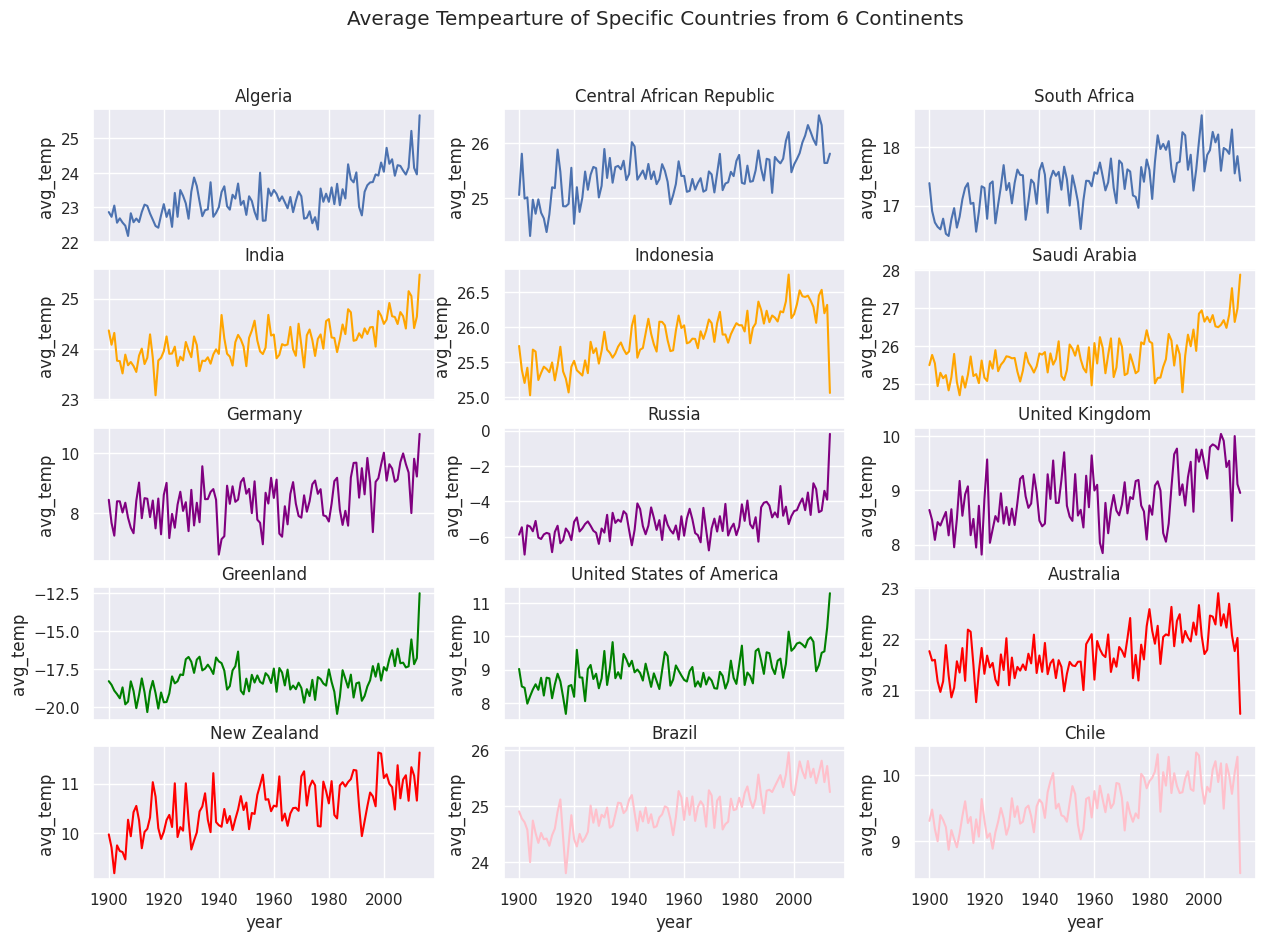

In [ ]:
#setup the subplot and create graph for each country
sns.set()
fig, axes = plt.subplots(5,3, figsize=(15, 10), sharex=True)
fig.suptitle("Average Tempearture of Specific Countries from 6 Continents")

#algeria
sns.lineplot(x= temp_africa[temp_africa.country == "Algeria"].year, y =temp_africa[temp_africa.country == "Algeria"].avg_temp, ax=axes[0][0])
axes[0][0].set_title("Algeria")

#Central African Republic
sns.lineplot(x= temp_africa[temp_africa.country == "Central African Republic"].year, y =temp_africa[temp_africa.country == "Central African Republic"].avg_temp, ax=axes[0][1])
axes[0][1].set_title("Central African Republic")

#South Africa
sns.lineplot(x= temp_africa[temp_africa.country == "South Africa"].year, y =temp_africa[temp_africa.country == "South Africa"].avg_temp, ax=axes[0][2])
axes[0][2].set_title("South Africa")

#Asia
#India
sns.lineplot(x= temp_asia[temp_asia.country == "India"].year, y =temp_asia[temp_asia.country == "India"].avg_temp, ax=axes[1][0], color="orange")
axes[1][0].set_title("India")

#Indonesia
sns.lineplot(x= temp_asia[temp_asia.country == "Indonesia"].year, y =temp_asia[temp_asia.country == "Indonesia"].avg_temp, ax=axes[1][1], color="orange")
axes[1][1].set_title("Indonesia")
#Saudi Arabia
sns.lineplot(x= temp_asia[temp_asia.country == "Saudi Arabia"].year, y =temp_asia[temp_asia.country == "Saudi Arabia"].avg_temp, ax=axes[1][2], color="orange")
axes[1][2].set_title("Saudi Arabia")


#EUROPE
#Germany
sns.lineplot(x= temp_europe[temp_europe.country == "Germany"].year, y =temp_europe[temp_europe.country == "Germany"].avg_temp, ax=axes[2][0], color="purple")
axes[2][0].set_title("Germany")
#Russia
sns.lineplot(x= temp_europe[temp_europe.country == "Russia"].year, y =temp_europe[temp_europe.country == "Russia"].avg_temp, ax=axes[2][1], color="purple")
axes[2][1].set_title("Russia")
#United Kingdom
sns.lineplot(x= temp_europe[temp_europe.country == "United Kingdom"].year, y =temp_europe[temp_europe.country == "United Kingdom"].avg_temp, ax=axes[2][2], color="purple")
axes[2][2].set_title("United Kingdom")

#NORTH AMERICA
#Greenland
sns.lineplot(x= temp_north_america[temp_north_america.country == "Greenland"].year, y =temp_north_america[temp_north_america.country == "Greenland"].avg_temp, ax=axes[3][0], color="green")
axes[3][0].set_title("Greenland")
#United States
sns.lineplot(x= temp_north_america[temp_north_america.country == "United States of America"].year, y =temp_north_america[temp_north_america.country == "United States of America"].avg_temp, ax=axes[3][1], color="green")
axes[3][1].set_title("United States of America")

#OCEANIA
#Australia
sns.lineplot(x= temp_oceania[temp_oceania.country == "Australia"].year, y =temp_oceania[temp_oceania.country == "Australia"].avg_temp, ax=axes[3][2], color="red")
axes[3][2].set_title("Australia")
#New Zealand
sns.lineplot(x= temp_oceania[temp_oceania.country == "New Zealand"].year, y =temp_oceania[temp_oceania.country == "New Zealand"].avg_temp, ax=axes[4][0], color="red")
axes[4][0].set_title("New Zealand")

#SOUTH AMERICA
#Brazil
sns.lineplot(x= temp_south_america[temp_south_america.country == "Brazil"].year, y =temp_south_america[temp_south_america.country == "Brazil"].avg_temp, ax=axes[4][1], color="pink")
axes[4][1].set_title("Brazil")
#Chile
sns.lineplot(x= temp_south_america[temp_south_america.country == "Chile"].year, y =temp_south_america[temp_south_america.country == "Chile"].avg_temp, ax=axes[4][2], color="pink")
axes[4][2].set_title("Chile")

plt.show()

#### **Observation**
There is an interesting trend in our plot. From initial observation, we can see an upward trend from 1980 onwards. Most notebaly, there is an average increase in temperature for most countries from 2000 onwards. United States, Greenland, Saudi Arabia, Algeria, and Russia had a sharp increase in their avg. temperature from 2010 onwards

### **2.1.3 Temperature Trend of Countries**

Lets find the hottest and coldest countries in world by their average temperature.

We will get the top 20 hottest country:

#### **Hottest Countries**

In [ ]:
#hottest countries in descending order of avg temp

top_20_hot_countries = temp_countries_yearly[["country", "avg_temp" ]].groupby("country")["avg_temp"].mean().reset_index().sort_values(by="avg_temp", ascending=False).head(15).copy()
top_20_hot_countries.reset_index(drop=True, inplace=True)
top_20_hot_countries

country   avg_temp
0                            Djibouti  28.885673
1                                Mali  28.615028
2                        Burkina Faso  28.284241
3                             Senegal  28.118683
4                               Aruba  28.104281
5                United Arab Emirates  27.871594
6                          Mauritania  27.790105
7                              Gambia  27.692663
8                               Niger  27.615232
9                             Curaçao  27.549154
10  Bonaire, Saint Eustatius And Saba  27.364756
11                              Benin  27.345622
12                              Palau  27.306609
13                               Chad  27.261496
14                      Palmyra Atoll  27.248114

Ranking the top 20 countries as a bar chart with their respective average temperature (for 1900-2013)

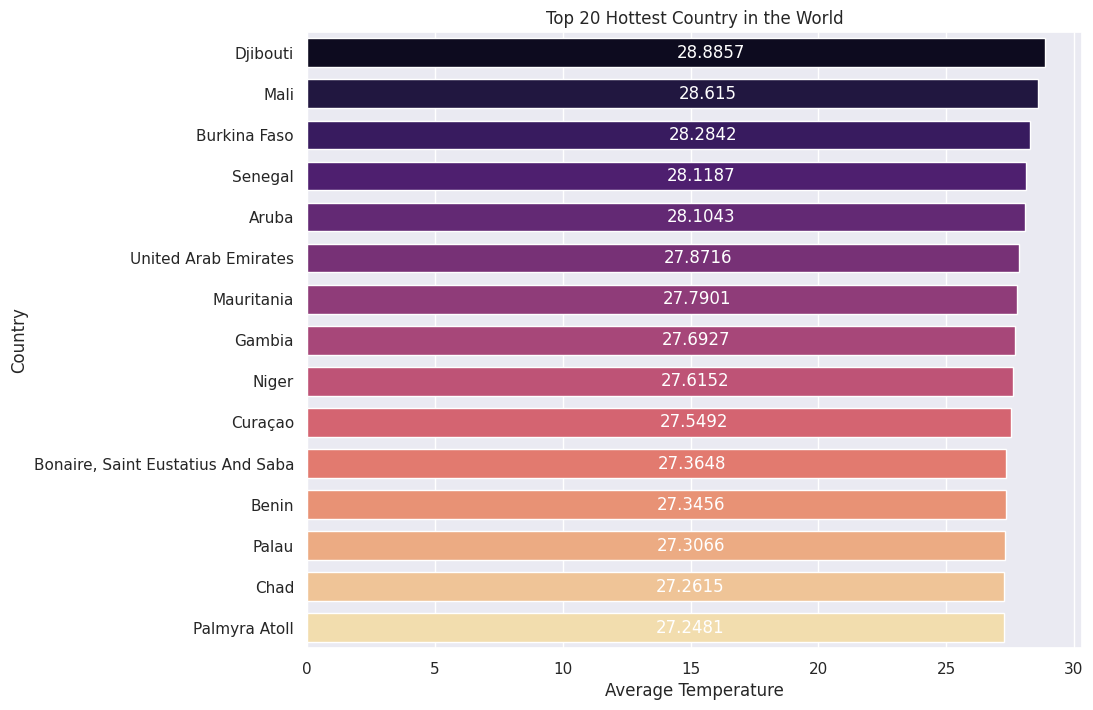

In [ ]:
plt.figure(figsize=(10,8))
ax = sns.barplot(y=top_20_hot_countries.country, x=top_20_hot_countries.avg_temp, width=0.7, palette="magma")
ax.bar_label(ax.containers[0], label_type = 'center',padding=25, color="white")
ax.set_xlabel("Average Temperature")
ax.set_ylabel("Country")
ax.set_title("Top 20 Hottest Country in the World")
plt.show()


#### **Coldest Countries**

Lets get the top 20 coldest countries by their average temperature

In [ ]:
#coldest countries in descending order of avg temp

top_20_cold_countries = temp_countries_yearly[["country", "avg_temp" ]].groupby("country")["avg_temp"].mean().reset_index().sort_values(by="avg_temp", ascending=True).head(15).copy()
top_20_cold_countries.reset_index(drop=True, inplace=True)
top_20_cold_countries

country   avg_temp
0                                      Greenland -18.152097
1                         Svalbard and Jan Mayen  -7.051755
2                                         Russia  -5.140921
3                                        Denmark  -4.740715
4                                         Canada  -4.736779
5                                       Mongolia  -0.498365
6                                         Norway   0.488553
7   South Georgia and the South Sandwich Islands   1.432852
8                                        Iceland   1.789179
9                                  North America   2.452538
10             Heard Island and McDonald Islands   2.579286
11                                        Sweden   2.768794
12                                    Kyrgyzstan   3.508410
13                                       Finland   3.671952
14                                    Tajikistan   4.289327

Ranking the top 20 coldest countries as a bar chart with their respective average temperature (for 1900-2013)

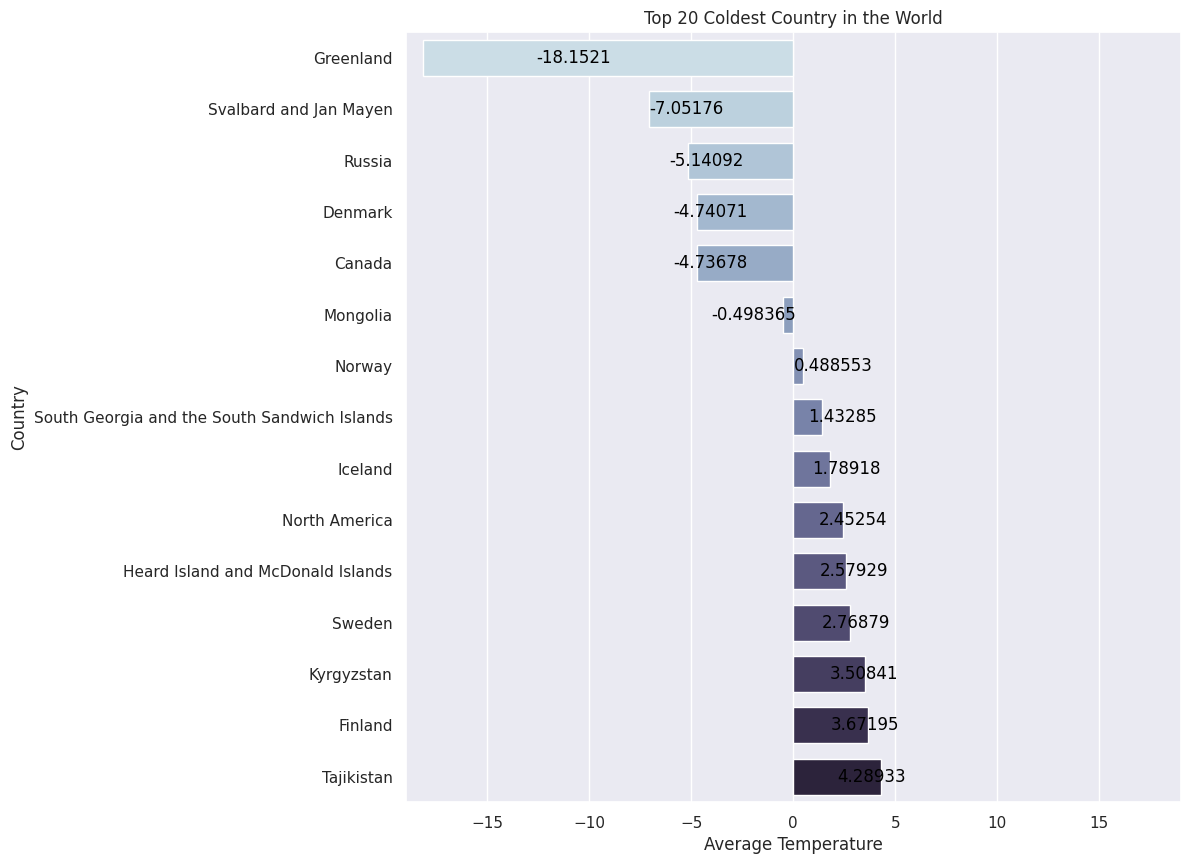

In [ ]:
plt.figure(figsize=(10,10))
ax = sns.barplot(y=top_20_cold_countries.country, x=top_20_cold_countries.avg_temp, width=0.7, palette="ch:s=.25,rot=-.25")
ax.bar_label(ax.containers[0], label_type = 'center',padding=25, color="black")
ax.set_xlim(-19,19)
ax.set_xlabel("Average Temperature")
ax.set_ylabel("Country")
ax.set_title("Top 20 Coldest Country in the World")
plt.show()

### **2.1.4** Temperature Trend by Hemisphere

<ipython-input-64-fe73fb90a121>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hemi_temps.loc[:,'hemisphere'] = hemi_temps.apply(lambda x: get_hemisphere(x), axis=1)


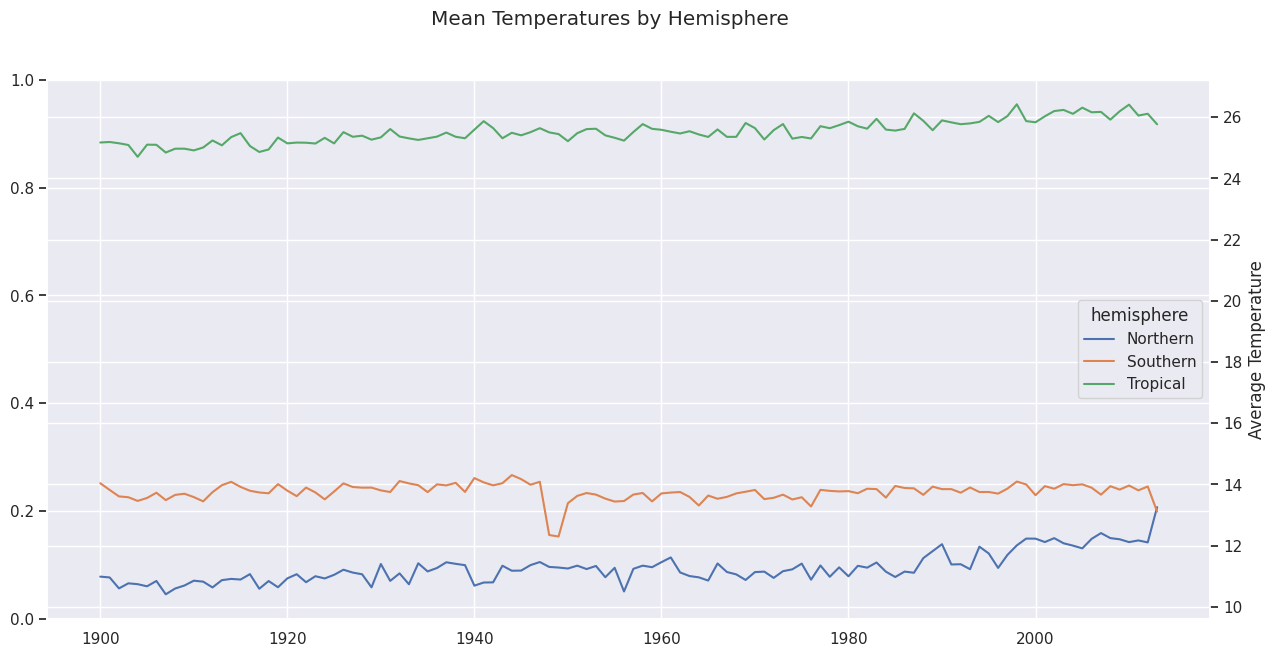

In [ ]:
def get_hemisphere(x):
  if x.is_tropical == 1:
    return 'Tropical'
  if x.is_northern == 1:
    return 'Northern'
  if x.is_southern == 1:
    return 'Southern'


hemi_temps = temp_countries[['dt','is_tropical','is_northern','is_southern','avg_temp']]
hemi_temps.loc[:,'hemisphere'] = hemi_temps.apply(lambda x: get_hemisphere(x), axis=1)
hemi_temps.loc[:,'dt'] = hemi_temps['dt'].apply(lambda x: x[:4])
hemi_temps = hemi_temps[['dt','hemisphere','avg_temp']]
hemi_temps = hemi_temps.groupby(by=["dt","hemisphere"]).mean().reset_index()
hemi_temps = hemi_temps.astype({'dt': 'int'})
#hemi_temps = hemi_temps[hemi_temps.dt.between(1960, 2015)].copy()
hemi_temps = hemi_temps.rename(columns={'dt':'year'})


fig, axes = plt.subplots(figsize=(15, 7))
fig.suptitle("Mean Temperatures by Hemisphere")
ax2=axes.twinx()
sns.lineplot(data=hemi_temps, x="year", y="avg_temp", hue="hemisphere", ax=ax2)
ax2.set_ylabel("Average Temperature")
plt.show()


#### **Observation**

We can see the noticeable rise in temperatures in the tropical and northern zones (most notably in the northern hemisphere).  The southern hemisphere seems odd, perhaps susceptible to insufficient data.

## **2.2 Exploring The Disaster Data**

We will clean the data a little and remove all the unwanted columns and store the data into a new variable geo_disasters_clean.

We will choose the columns to drop based on either their redunancy, significance, or nullness.

Our first goal is to see the total number of each kind of disaster in our dataset.

### **2.2.1 Types of Disaster**

First, we take a look at the distribution of disasters by type.

In [ ]:
geo_disasters.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37096 entries, 0 to 39952
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            37096 non-null  object 
 1   country       37096 non-null  object 
 2   iso3          36802 non-null  object 
 3   gwno          36696 non-null  float64
 4   year          37096 non-null  int64  
 5   geo_id        37096 non-null  int64  
 6   geolocation   37096 non-null  object 
 7   level         37096 non-null  int64  
 8   adm1          37096 non-null  object 
 9   adm2          12555 non-null  object 
 10  adm3          2107 non-null   object 
 11  location      37096 non-null  object 
 12  historical    37096 non-null  int64  
 13  hist_country  173 non-null    object 
 14  disastertype  37096 non-null  object 
 15  disasterno    37096 non-null  object 
 16  latitude      37096 non-null  float64
 17  longitude     37096 non-null  float64
 18  is_tropical   37096 non-null  i

In [ ]:
geo_disasters.head(3)

id  country iso3   gwno  year  geo_id  geolocation  level     adm1   
0  109  Albania  ALB  339.0  2009     346  Ana E Malit      3  Shkoder  \
1  109  Albania  ALB  339.0  2009     351       Bushat      3  Shkoder   
2  175   Angola  AGO  540.0  2001     760       Onjiva      3   Cunene   

       adm2  ...     location historical  hist_country disastertype   
0  Shkodres  ...  Ana E Malit          0           NaN        flood  \
1  Shkodres  ...       Bushat          0           NaN        flood   
2  Cuanhama  ...       Onjiva          0           NaN        flood   

  disasterno   latitude  longitude  is_tropical  is_northern  is_southern  
0  2009-0631  42.020948  19.418317            0            1            0  
1  2009-0631  41.959294  19.514309            0            1            0  
2  2001-0146 -17.093484  15.665758            1            0            0  

[3 rows x 21 columns]

In [ ]:
print("Number of different disaster levels: ", geo_disasters.level.unique(), "\n")
print("Number of different historical values: ", geo_disasters.historical.unique(), "\n")
print("Different kinds of disaster types: ", geo_disasters.disastertype.unique(), "\n")
print("Number of countries in our data: ", len(geo_disasters.country.unique()), "\n")
print("Number of geolocations in our data: ", len(geo_disasters.geolocation.unique()), "\n")

Number of different disaster levels:  [3 2 1] 

Number of different historical values:  [0 1] 

Different kinds of disaster types:  ['flood' 'storm' 'extreme temperature ' 'landslide' 'drought'] 

Number of countries in our data:  197 

Number of geolocations in our data:  9239 



In [ ]:
#Transform the data to drop unwanted columns
drop_labels = ["iso3", "gwno", "adm1", "adm2", "adm3", "location", "hist_country", "geo_id", "disasterno", "historical"]
geo_disasters_clean = geo_disasters.drop(labels=drop_labels, axis=1)
geo_disasters_clean.head(3)

id  country  year  geolocation  level disastertype   latitude  longitude   
0  109  Albania  2009  Ana E Malit      3        flood  42.020948  19.418317  \
1  109  Albania  2009       Bushat      3        flood  41.959294  19.514309   
2  175   Angola  2001       Onjiva      3        flood -17.093484  15.665758   

   is_tropical  is_northern  is_southern  
0            0            1            0  
1            0            1            0  
2            1            0            0

In [ ]:
total_count_disasters = geo_disasters_clean.groupby("disastertype")[["country"]].count().reset_index().rename(columns={"country": "count"})

total_count_disasters

disastertype  count
0               drought   2938
1  extreme temperature    3506
2                 flood  17347
3             landslide    982
4                 storm  12323

The data showed that the leading disaster types are flood and storms.

Extreme temperature, drought, and earthquake have occurred at almost similar rate.

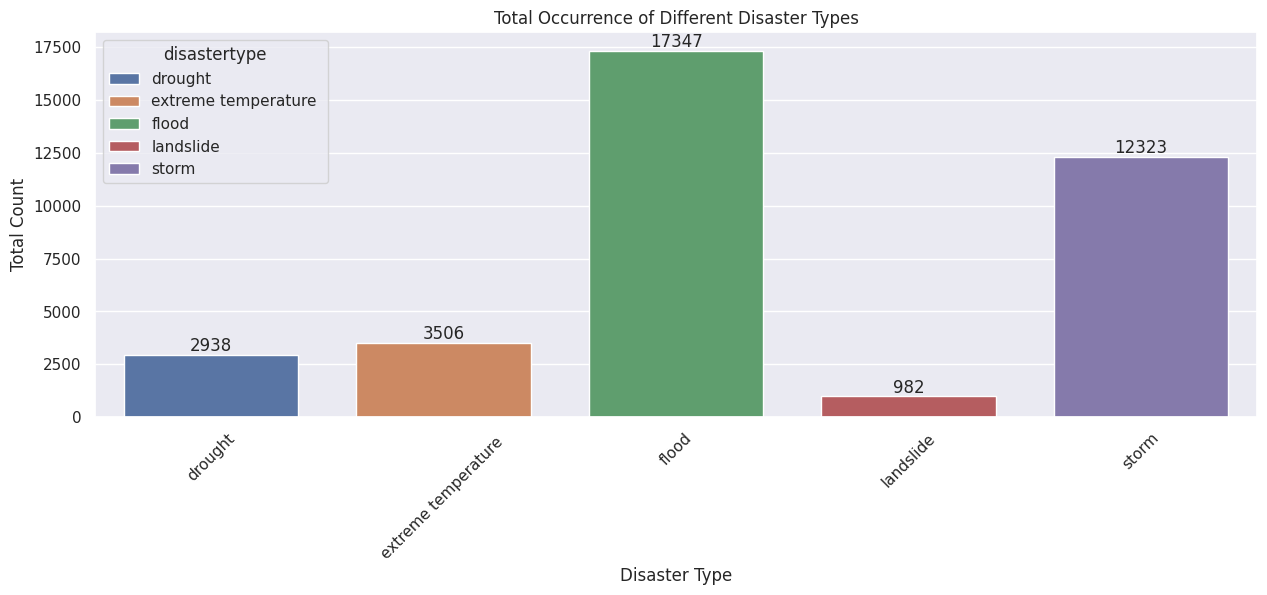

In [ ]:
#plot the occurrence of each disaster type
plt.figure(figsize=(15,5))
axes = sns.barplot(data=total_count_disasters, x="disastertype", y="count", hue="disastertype", width=0.75, dodge=False)
for bars in axes.containers:
  axes.bar_label(bars)
axes.set_xlabel("Disaster Type")
axes.set_ylabel("Total Count")
axes.set_title("Total Occurrence of Different Disaster Types")
plt.xticks(rotation=45)
plt.show()


### **2.2.2 Compare Temperature and Disaster**

Let us see if there is any relationship between the change in temperature over the years and the occurence of disasters.

For the comparions, we will use the global tempraure dataset and we will create a new dataframe called geo_disasters_yearly to see the total number of disasters per year. Additionally, we will clean the global data and store it as temp_global_clean.

Because the range for the two dataframe are different, we will limit our data year from 1960 to 2015.


From the graph below, we can clearly see an overlapping trend between the disaster count and the global average temperature. There is an increase that is noticed after the year 1990, and a pronounced difference from 2000 onwards compared to the previous years.

Although, the cause and effect relation can be debated as many different factors needs to be considered. We can clearly see an increase in number of disaster as the global average temperature is increasing.



In [ ]:
#create a new dataframe to get number of disasters per year

geo_disasters_yearly = geo_disasters_clean.groupby(by="year")[["disastertype"]].count().reset_index().rename(columns={"disastertype":"count"})

print(geo_disasters_yearly.year.min())
print(geo_disasters_yearly.year.max())

1960
2018


In [ ]:
#clean the global temp data to get only the columns and data needed
# and rename the dt to year
temp_global_clean = temp_global[["dt", "LandAndOceanAverageTemperature", "LandAndOceanAverageTemperatureUncertainty", "LandAverageTemperature"]].copy()
temp_global_clean.dt = pd.to_datetime(temp_global_clean.dt).dt.year
temp_global_clean.rename(columns={"dt":"year"}, inplace=True)
temp_global_clean.dropna(inplace=True)

print(temp_global_clean.year.min())
print(temp_global_clean.year.max())


1850
2015


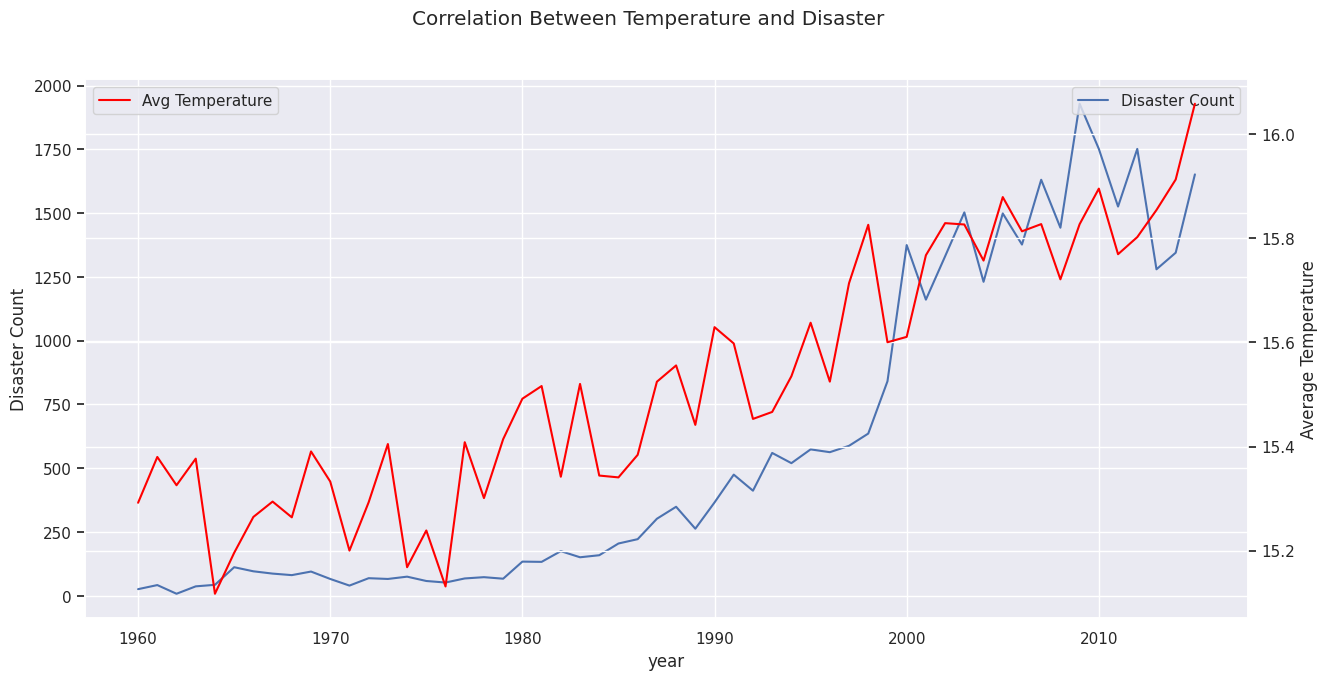

In [ ]:
# limiting the range of year to 1960-2015 in order to compensate for the range diference between the two dataset.

geo_disasters_limited = geo_disasters_yearly[geo_disasters_yearly.year.between(1960, 2015)].copy()
temp_global_clean_limited = temp_global_clean[temp_global_clean.year.between(1960, 2015)].copy()
temp_global_clean_limited = temp_global_clean_limited.groupby("year").mean().reset_index()


fig, axes = plt.subplots(figsize=(15, 7))
fig.suptitle("Correlation Between Temperature and Disaster")
ax2=axes.twinx()

# sns.lineplot(x= temp_global_clean_limited.year, y =temp_global_clean_limited.LandAndOceanAverageTemperature)
sns.lineplot(data=geo_disasters_limited, x="year", y="count", ax=axes)
axes.set_ylabel("Disaster Count")
axes.legend(["Disaster Count"], loc="upper right")
sns.lineplot(data=temp_global_clean_limited, x="year", y="LandAndOceanAverageTemperature", ax=ax2, color="red")
ax2.set_ylabel("Average Temperature")
ax2.legend(["Avg Temperature"], loc="upper left")
plt.show()


### **2.2.3** Compare temperature against each type of disaster

From the graph below, we can clearly see an overlapping trend between the global average temperature, and both floods and storms, predominantly.

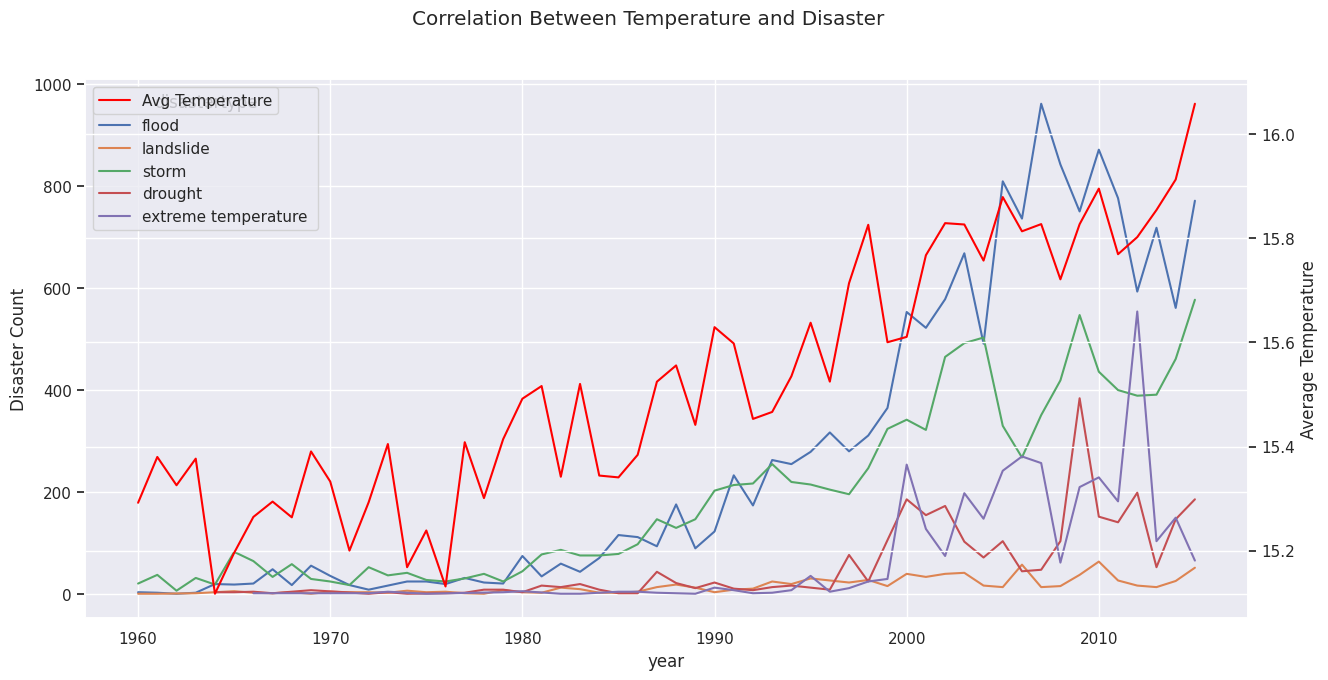

In [ ]:
# limiting the range of year to 1960-2015 in order to compensate for the range diference between the two dataset.

geo_disasters_yearly_with_type = geo_disasters_clean.groupby(by=["year","disastertype"]).count().reset_index().rename(columns={"id":"count"})
geo_disasters_limited = geo_disasters_yearly_with_type[geo_disasters_yearly_with_type.year.between(1960, 2015)].copy()
temp_global_clean_limited = temp_global_clean[temp_global_clean.year.between(1960, 2015)].copy()
temp_global_clean_limited = temp_global_clean_limited.groupby("year").mean().reset_index()


fig, axes = plt.subplots(figsize=(15, 7))
fig.suptitle("Correlation Between Temperature and Disaster")
ax2=axes.twinx()

# sns.lineplot(x= temp_global_clean_limited.year, y =temp_global_clean_limited.LandAndOceanAverageTemperature)
sns.lineplot(data=geo_disasters_limited, x="year", y="count", hue="disastertype", ax=axes)
axes.set_ylabel("Disaster Count")
#axes.legend(["Disaster Count"], loc="upper right")
sns.lineplot(data=temp_global_clean_limited, x="year", y="LandAndOceanAverageTemperature", ax=ax2, color="red")
ax2.set_ylabel("Average Temperature")
ax2.legend(["Avg Temperature"], loc="upper left")
plt.show()



### **2.2.4** Disasters by hemisphere

We see a signficant rise in disasters for both the northern and tropical zones.  The southern zone also see an increase, but much less significant.  It should also be noted that the same pattern was found in rising temperatures, where the most change was seen in the northern and tropical zones, and minimal effect in the southern.





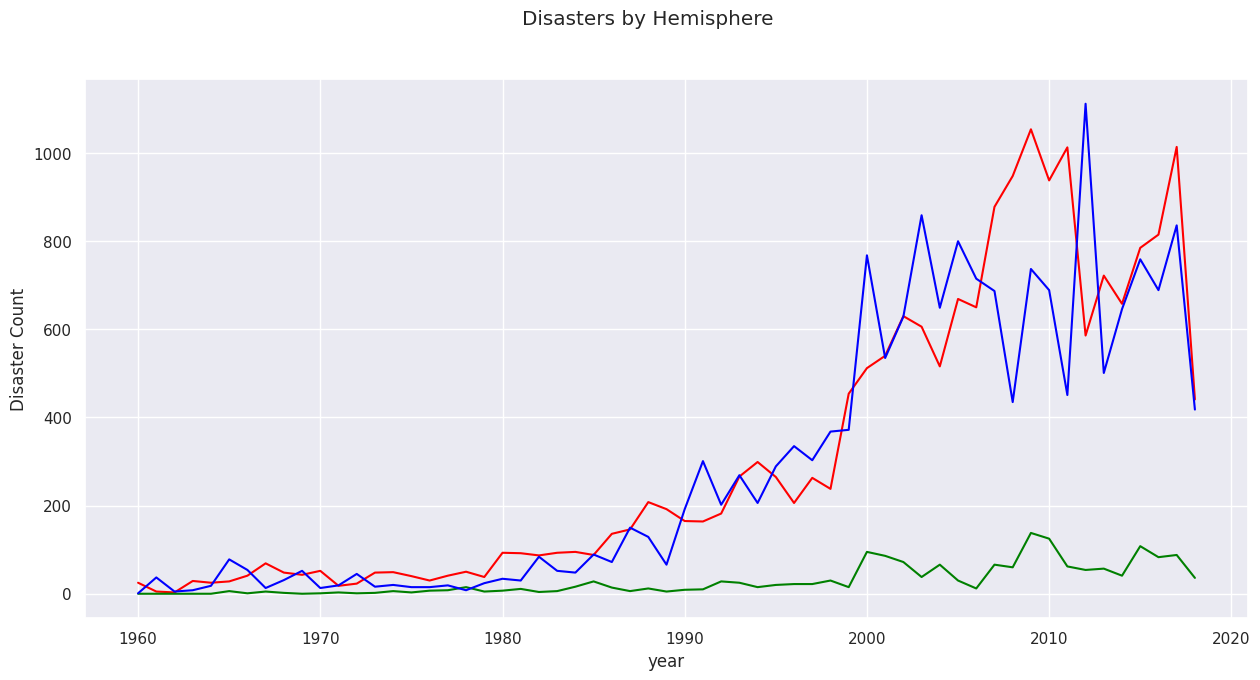

In [ ]:

hemi_disasters = geo_disasters_clean[['year','is_tropical', 'is_northern','is_southern']]
hemi_disasters = hemi_disasters.groupby(by=["year"]).sum().reset_index()


fig, axes = plt.subplots(figsize=(15, 7))
fig.suptitle("Disasters by Hemisphere")

s1 = sns.lineplot(data=hemi_disasters, x="year", y='is_tropical', color="red", legend='auto')
sns.lineplot(data=hemi_disasters, x="year", y='is_southern', color="green")
sns.lineplot(data=hemi_disasters, x="year", y='is_northern', color="blue")
axes.set_ylabel("Disaster Count")
plt.show()


### **2.2.5 Disaster Data For Hot Countries**

Based on our previous data exploration we have a list of top 20 hottest countries. In this section, we will explore the disaster data for the top five hottest countries. From initial review, we are missing data for Aruba and UAE so will exlude those 2 from our analysis.

We will plot the ccountry's disaster count as a barplot next to a lineplot of their average temp. The average temperature data will be limited to the range of year within our disaster data.

When looking at the data, one aspect which stands out is that the disaster type for hottest countries are mostly flood and drought. This is in contrast to the leading global disaster type which were flood and storms.

In [ ]:
#geo_disasters_clean
hot_countries = top_20_hot_countries.country.unique()


#lets get the disaster data for hot countries

geo_disasters_hot = geo_disasters_clean[geo_disasters_clean.country.isin(hot_countries)].copy()

geo_disasters_hot.drop(["id", "level", "latitude", "longitude"], axis=1, inplace=True)
geo_disasters_hot  = geo_disasters_hot.groupby(by=["country", "year","disastertype"]).count().reset_index()

geo_disasters_hot = geo_disasters_hot.sort_values(by=["country", "year", "disastertype"]).rename(columns={"geolocation":"disaster_count"})

list(top_20_hot_countries.country)

['Djibouti',
 'Mali',
 'Burkina Faso',
 'Senegal',
 'Aruba',
 'United Arab Emirates',
 'Mauritania',
 'Gambia',
 'Niger',
 'Curaçao',
 'Bonaire, Saint Eustatius And Saba',
 'Benin',
 'Palau',
 'Chad',
 'Palmyra Atoll']

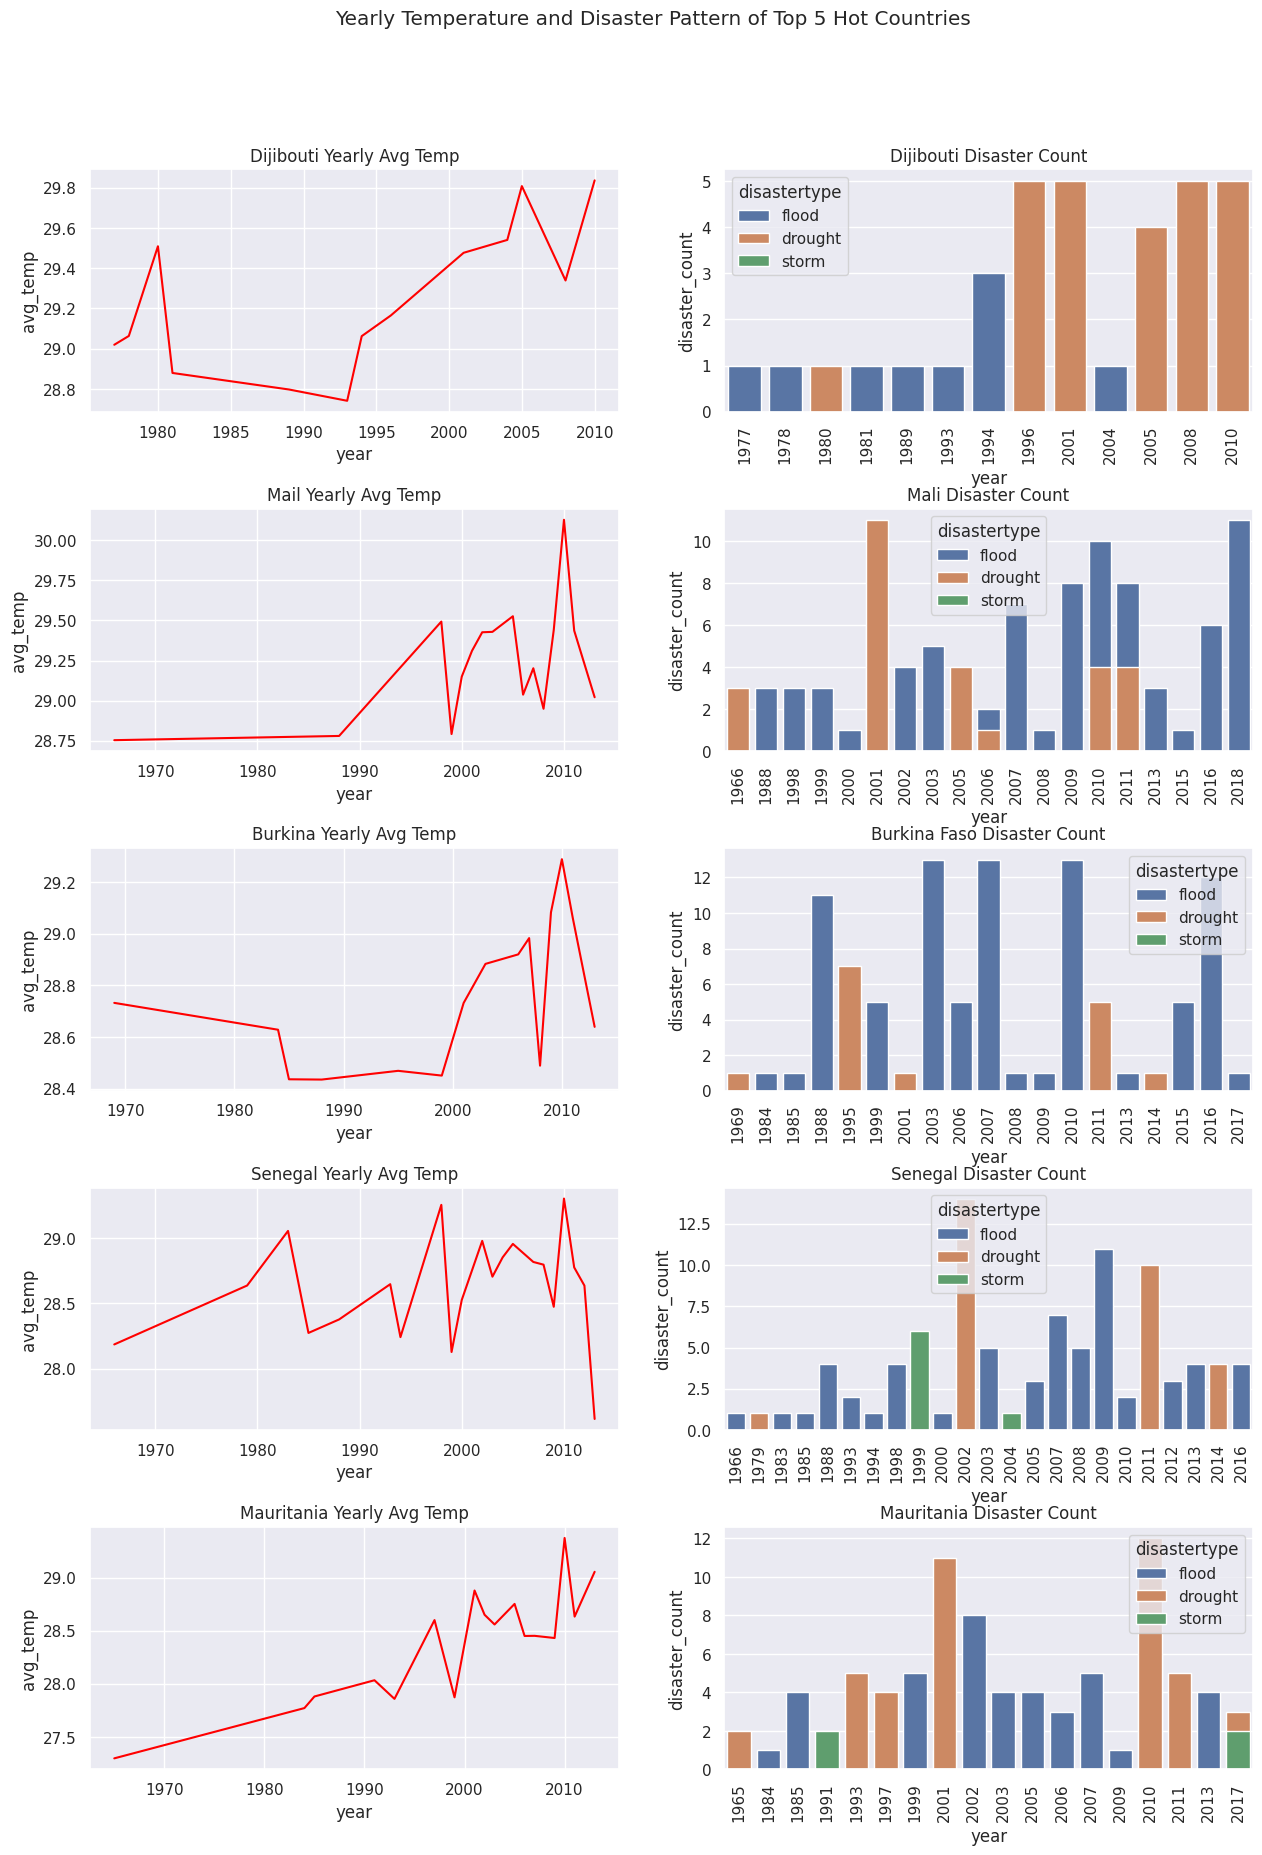

In [ ]:
# Get the temp Data for countries based of the years from their disaster data

#djibouti
year_list_djibouti = list(geo_disasters_hot[geo_disasters_hot.country == "Djibouti"].year)
djibouti_temp = temp_countries_yearly[(temp_countries_yearly.country == "Djibouti") & (temp_countries_yearly.year.isin(year_list_djibouti))].copy()


#mali
year_list_mali = list(geo_disasters_hot[geo_disasters_hot.country == "Mali"].year)
mali_temp = temp_countries_yearly[(temp_countries_yearly.country == "Mali") & (temp_countries_yearly.year.isin(year_list_mali))].copy()


#Burkina Faso
year_list_burkina = list(geo_disasters_hot[geo_disasters_hot.country == "Burkina Faso"].year)
burkina_temp = temp_countries_yearly[(temp_countries_yearly.country == "Burkina Faso") & (temp_countries_yearly.year.isin(year_list_burkina))].copy()
burkina_temp
#Senegal
year_list_senegal = list(geo_disasters_hot[geo_disasters_hot.country == "Senegal"].year)
senegal_temp = temp_countries_yearly[(temp_countries_yearly.country == "Senegal") & (temp_countries_yearly.year.isin(year_list_senegal))].copy()
senegal_temp

#Aruba and UAE skipped due to lack of data

#Mauritania
year_list_mauritania = list(geo_disasters_hot[geo_disasters_hot.country == "Mauritania"].year)
mauritania_temp = temp_countries_yearly[(temp_countries_yearly.country == "Mauritania") & (temp_countries_yearly.year.isin(year_list_mauritania))].copy()



## Avg Temp and Disaster Count of top 5 hot countries
fig, axes = plt.subplots(5,2, figsize=(15,20))
fig.suptitle("Yearly Temperature and Disaster Pattern of Top 5 Hot Countries")

plt.subplots_adjust(bottom=0.1,top=0.9,wspace=0.2,hspace=0.4)
hue_order=['flood', 'drought', 'storm']

dji_disas = sns.barplot(data=geo_disasters_hot[geo_disasters_hot.country == "Djibouti"], x="year", y="disaster_count", hue="disastertype", hue_order=hue_order, ax=axes[0][1], dodge=False).set_title("Dijibouti Disaster Count")
dji_temp = sns.lineplot(data=djibouti_temp, x="year", y="avg_temp", ax=axes[0][0], color="red").set_title("Dijibouti Yearly Avg Temp")

mali_disas = sns.barplot(data=geo_disasters_hot[geo_disasters_hot.country == "Mali"], x="year", y="disaster_count", hue="disastertype", hue_order=hue_order, ax=axes[1][1], dodge=False).set_title("Mali Disaster Count")
mali_temp = sns.lineplot(x=mali_temp.year, y=mali_temp.avg_temp, ax=axes[1][0], color="red").set_title("Mail Yearly Avg Temp")


burkina_disas = sns.barplot(data=geo_disasters_hot[geo_disasters_hot.country == "Burkina Faso"], x="year", y="disaster_count", hue="disastertype", hue_order=hue_order, ax=axes[2][1], dodge=False).set_title("Burkina Faso Disaster Count")
burkina_temp = sns.lineplot(x=burkina_temp.year, y=burkina_temp.avg_temp, ax=axes[2][0], color="red").set_title("Burkina Yearly Avg Temp")


senegal_disas = sns.barplot(data=geo_disasters_hot[geo_disasters_hot.country == "Senegal"], x="year", y="disaster_count", hue="disastertype",hue_order=hue_order, ax=axes[3][1], dodge=False).set_title("Senegal Disaster Count")
senegal_temp = sns.lineplot(x=senegal_temp.year, y=senegal_temp.avg_temp, ax=axes[3][0], color="red").set_title("Senegal Yearly Avg Temp")

mauritania_disas = sns.barplot(data=geo_disasters_hot[geo_disasters_hot.country == "Mauritania"], x="year", y="disaster_count", hue="disastertype", hue_order=hue_order, ax=axes[4][1], dodge=False).set_title("Mauritania Disaster Count")
mauritania_temp = sns.lineplot(x=mauritania_temp.year, y=mauritania_temp.avg_temp, ax=axes[4][0], color="red").set_title("Mauritania Yearly Avg Temp")

for i in range(5):
  axes[i][1].tick_params(axis='x', labelrotation=90)

plt.show()

In [ ]:
hot_countries_disaster_count =geo_disasters_hot.groupby(by=["disastertype"]).count()
hot_countries_disaster_count

country  year  disaster_count  is_tropical  is_northern   
disastertype                                                            
drought            43    43              43           43           43  \
flood             123   123             123          123          123   
storm              14    14              14           14           14   

              is_southern  
disastertype               
drought                43  
flood                 123  
storm                  14

In [ ]:
selected_columns = ['Jan record high C', 'Feb record high C', 'Mar record high C', 'Apr record high C', 'May record high C',
                    'Jun record high C', 'Jul record high C', 'Aug record high C', 'Sep record high C', 'Oct record high C',
                    'Nov record high C', 'Dec record high C']
wiki_climate['average_high_temp'] = wiki_climate[selected_columns].mean(axis = 1)
wiki_climate = wiki_climate.dropna(subset=['location'])

In [ ]:
wiki_climate = wiki_climate.reset_index().sort_values(by="average_high_temp", ascending=False).head(20).round(2)
wiki_climate.reset_index(drop=True, inplace=True)
wiki_climate

index                                           location   
0    5538        Timbuktu (1950–2000, extremes 1897–present)  \
1     393                                              Mecca   
2    2249          Atbara (1961–1990, extremes 1943–present)   
3    1439                                       Aswan, Egypt   
4     532       N'Djamena (1961–1990, extremes 1904–present)   
5     428                                Al Ahsa (1985–2010)   
6    3451                                  Indio, California   
7    1022         Kassala (1961–1990, extremes 1901–present)   
8    6885                              La Quinta, California   
9    1710                                        Qena, Egypt   
10   4853  Palm Springs Fire Station 2, California (1981–...   
11   4620  Palm Desert, California, elev. {{convert|10|ft...   
12   5101          Coachella, California (1981–2010 normals)   
13   6563     Palm Springs Int'l Airport (1981–2010 normals)   
14    757                                             Muscat   
15    115                               Khartoum (1971–2000)   
16    213                                 Jeddah (1985-2010)   
17    620  Hermosillo, Sonora (1981–2010, extremes (1973-...   
18   8629                                       Imperial, CA   
19    773           Al Ain International Airport (1995–2017)   

    Jan record high C  Feb record high C  Mar record high C   
0                41.6               43.5               46.1  \
1                37.4               38.3               42.4   
2                41.0               42.0               45.7   
3                35.3               38.5               44.0   
4                41.8               47.6               46.5   
5                32.7               37.8               41.2   
6                36.1               37.8               40.0   
7                41.7               43.5               45.3   
8                36.1               37.8               39.4   
9                33.0               37.0               43.0   
10               35.0               37.2               40.0   
11               36.1               37.8               39.4   
12               35.0               37.2               40.0   
13               35.0               37.2               40.0   
14               34.6               38.2               41.5   
15               39.7               42.5               45.2   
16               35.0               36.0               40.2   
17               35.0               38.0               41.5   
18               35.6               35.6               40.0   
19               31.8               36.6               42.9   

    Apr record high C  May record high C  Jun record high C   
0                48.9               49.0               49.0  \
1                44.7               49.4               49.6   
2                47.1               47.5               47.7   
3                46.1               47.8               50.6   
4                48.3               49.1               44.0   
5                45.0               49.0               50.6   
6                43.3               49.4               50.6   
7                46.0               47.0               47.6   
8                42.8               47.2               50.6   
9                46.0               50.0               50.0   
10               44.4               46.7               50.0   
11               42.8               47.2               50.6   
12               44.4               46.7               49.4   
13               44.4               46.7               49.4   
14               44.9               48.3               48.5   
15               46.2               46.8               46.3   
16               44.5               48.2               52.0   
17               44.0               46.0               49.5   
18               42.8               47.8               50.6   
19               44.4               49.3               49.0   

    Jul rec

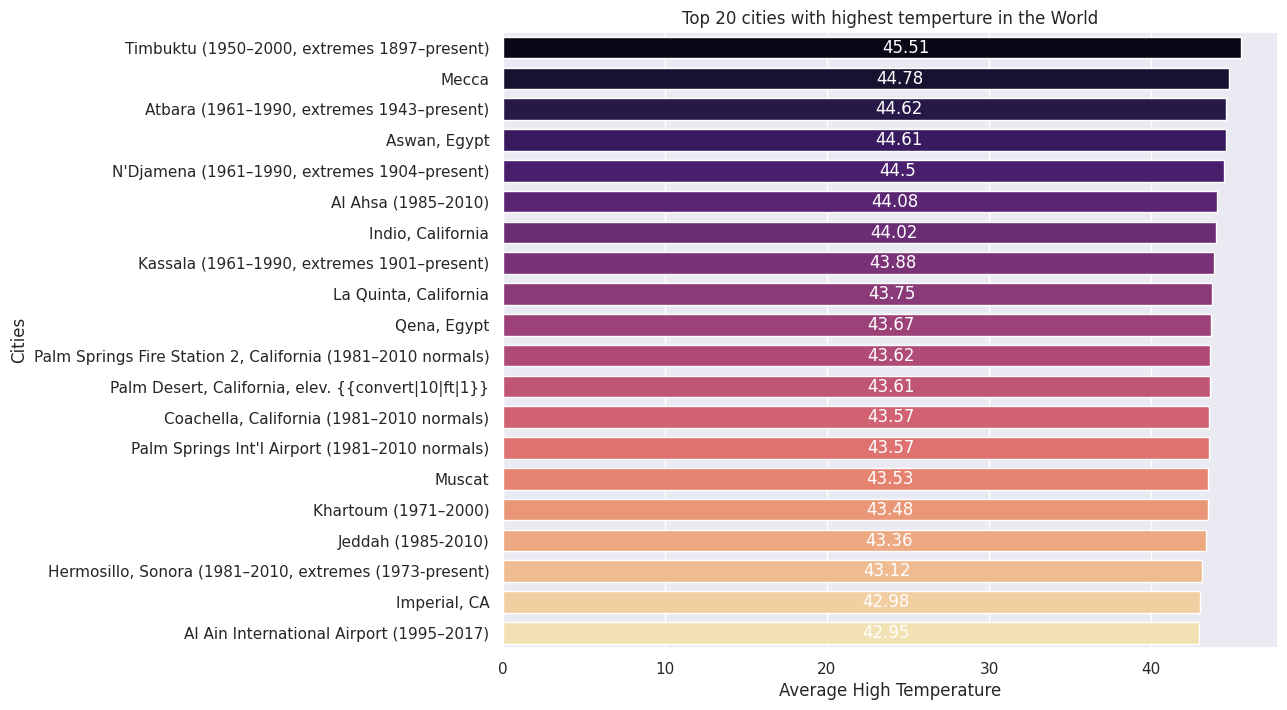

In [ ]:
plt.figure(figsize=(10,8))
ax = sns.barplot(y=wiki_climate.location, x=wiki_climate.average_high_temp, width=0.7, palette="magma")
ax.bar_label(ax.containers[0], label_type = 'center',padding=25, color="white")
ax.set_xlabel("Average High Temperature")
ax.set_ylabel("Cities")
ax.set_title("Top 20 cities with highest temperture in the World")
plt.show()

# **3.0 Analysis: Time Series Analysis of Temperature Data**

### **3.1 Seasonality & Trend of Temp Data**

First, we'll do a basic time series analysis of USA temperatures over time.


#### USA Temp Trend

The seasonality of the data shows big annual swings in the temperatures.

Text(0.5, 1.0, 'Seasonal Temperature Variation of United States')

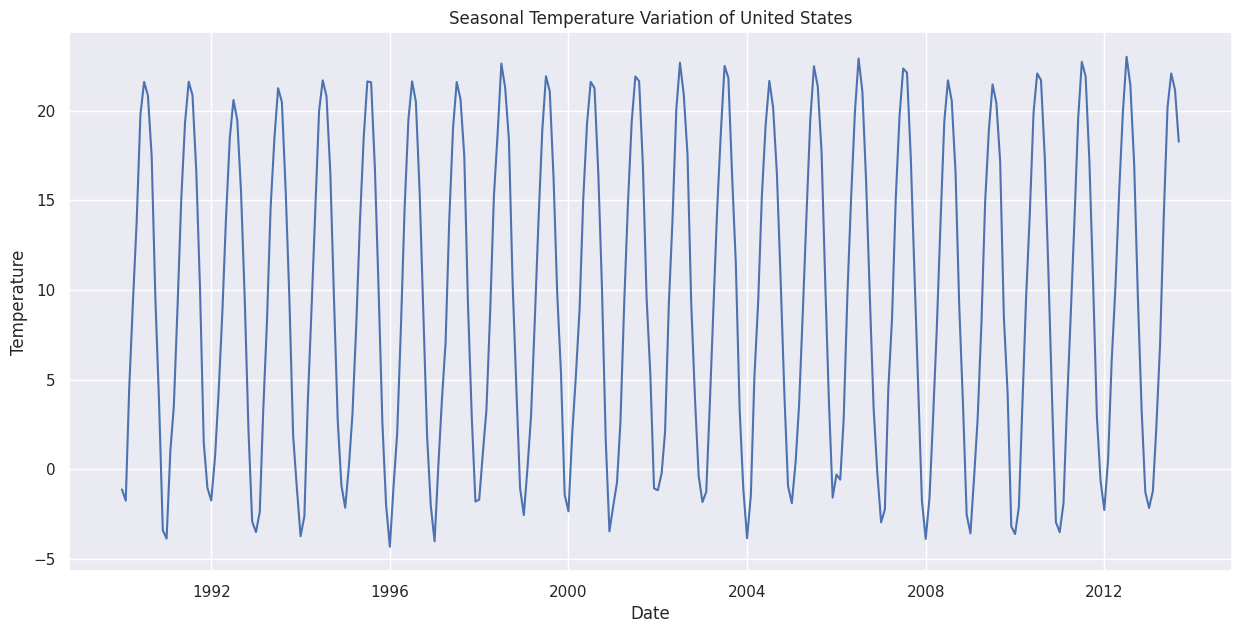

In [ ]:
#get USA temp data

united_states_temp = temp_countries.query("country == 'United States of America'").copy()

united_states_temp.drop("avg_temp_uncertainty", axis=1, inplace=True)
united_states_temp.dt = pd.to_datetime(united_states_temp.dt)

# us temp data from 1990-2014
united_states_temp_limited = united_states_temp[pd.DatetimeIndex(united_states_temp.dt).year.isin(range(1990,2014))]


plt.figure(figsize=(15,7))
us_plot = sns.lineplot(x=united_states_temp_limited.dt, y=united_states_temp_limited.avg_temp)
us_plot.set_xlabel("Date")
us_plot.set_ylabel("Temperature")
us_plot.set_title("Seasonal Temperature Variation of United States")


Using Statistical decomposition with moving averages has a big impact on removing those large swings and making it more obvious what the trend actually looks like.

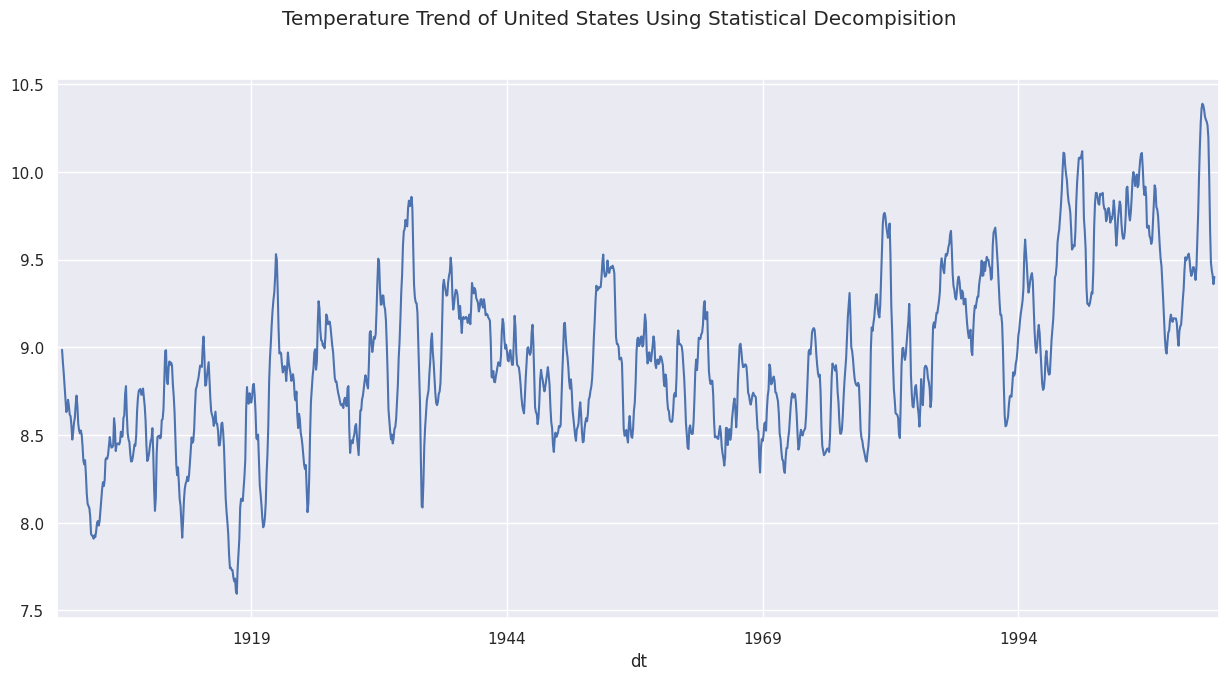

In [ ]:
#Trend using Statistical decomposition using moving averages.

import statsmodels.api as sm
from matplotlib import rcParams

us_decompose = united_states_temp[["dt", "avg_temp"]].set_index(united_states_temp.dt).drop(["dt"], axis=1)

plt.figure(figsize=(15,7))
plt.suptitle("Temperature Trend of United States Using Statistical Decompisition")
decomposition = sm.tsa.seasonal_decompose(us_decompose)
us_decompose_plot = decomposition.trend.plot()



plt.show()

In [ ]:
us_decompose = united_states_temp[["dt", "avg_temp"]].set_index(united_states_temp.dt).drop(["dt"], axis=1)


#### Global Trend

Using Statistical decomposition with moving averages on the global data paints an even more dramatic picture of the trend in the data, seeing significant change begin around 1980.

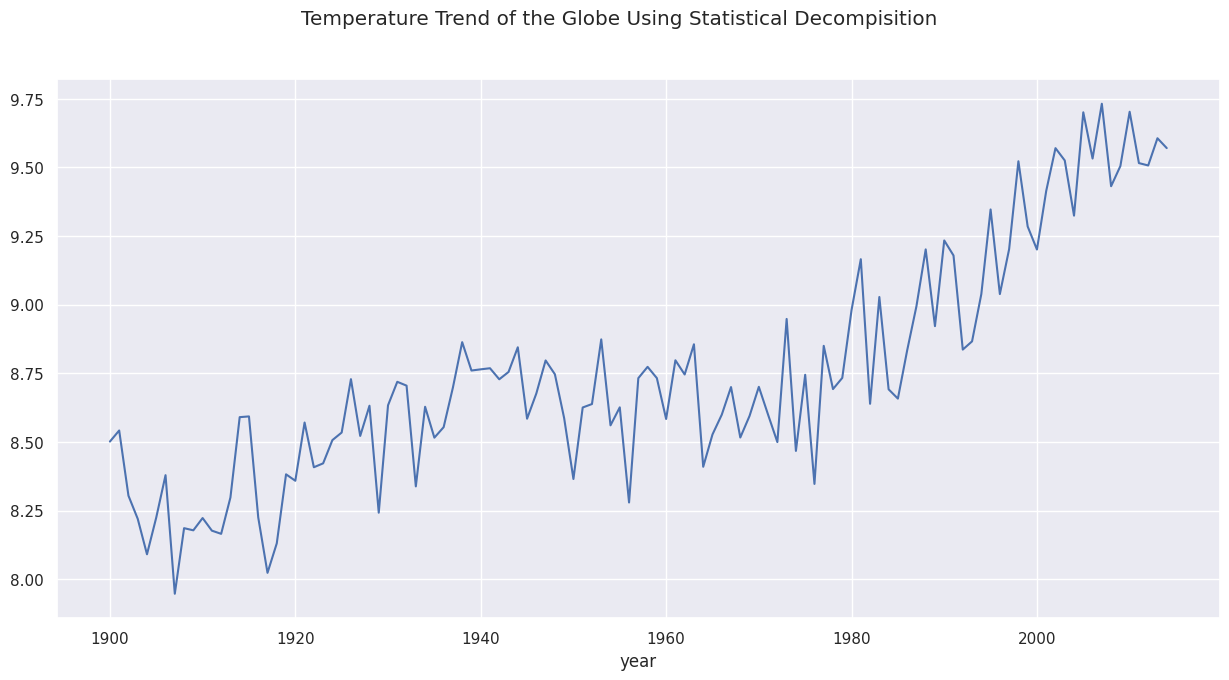

In [ ]:
import statsmodels.api as sm
from matplotlib import rcParams

temp_global_clean_1900 = temp_global_clean[temp_global_clean.year.between(1900, 2014)].copy()
temp_global_clean_1900 = temp_global_clean_1900.groupby("year").mean().reset_index()
temp_global_clean_1900

global_temp = temp_global_clean_1900[["year","LandAverageTemperature"]].set_index(temp_global_clean_1900.year).drop(["year"], axis=1)

plt.figure(figsize=(15,7))
plt.suptitle("Temperature Trend of the Globe Using Statistical Decompisition")
decomposition = sm.tsa.seasonal_decompose(global_temp, model='additive', period=1)
global_decomposition_plot = decomposition.trend.plot()



plt.show()

### **3.2 USA Monthly Trend 1990-2013**

Question: Is there any monthly difference in temperature?

The winter months seem to have increased more over time, but this chart still reinforces the general trend of warming temperatures for the year, in all months.


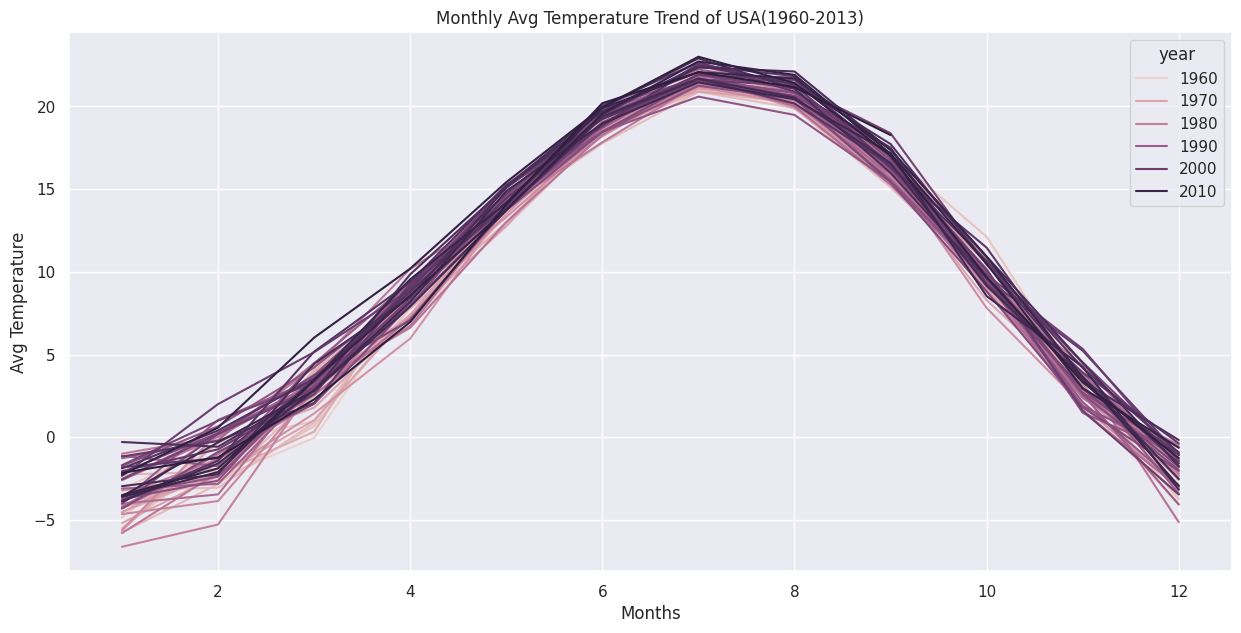

In [ ]:
# seeing monthly trend in temperature every year
united_states_temp['month'] = united_states_temp.dt.dt.month
united_states_temp['year'] = united_states_temp.dt.dt.year
plt.figure(figsize=(15,7))
monthly_plot = sns.lineplot(data=united_states_temp[united_states_temp.year.between(1960,2013)], x="month", y="avg_temp", hue="year")
monthly_plot.set_xlabel("Months")
monthly_plot.set_ylabel("Avg Temperature")
monthly_plot.set_title("Monthly Avg Temperature Trend of USA(1960-2013)")
plt.show()

### **3.3 Monthly Temperature Trend of Hemisphere**

#### Temp Variation By Region
Question: Does Temperature vary by region?

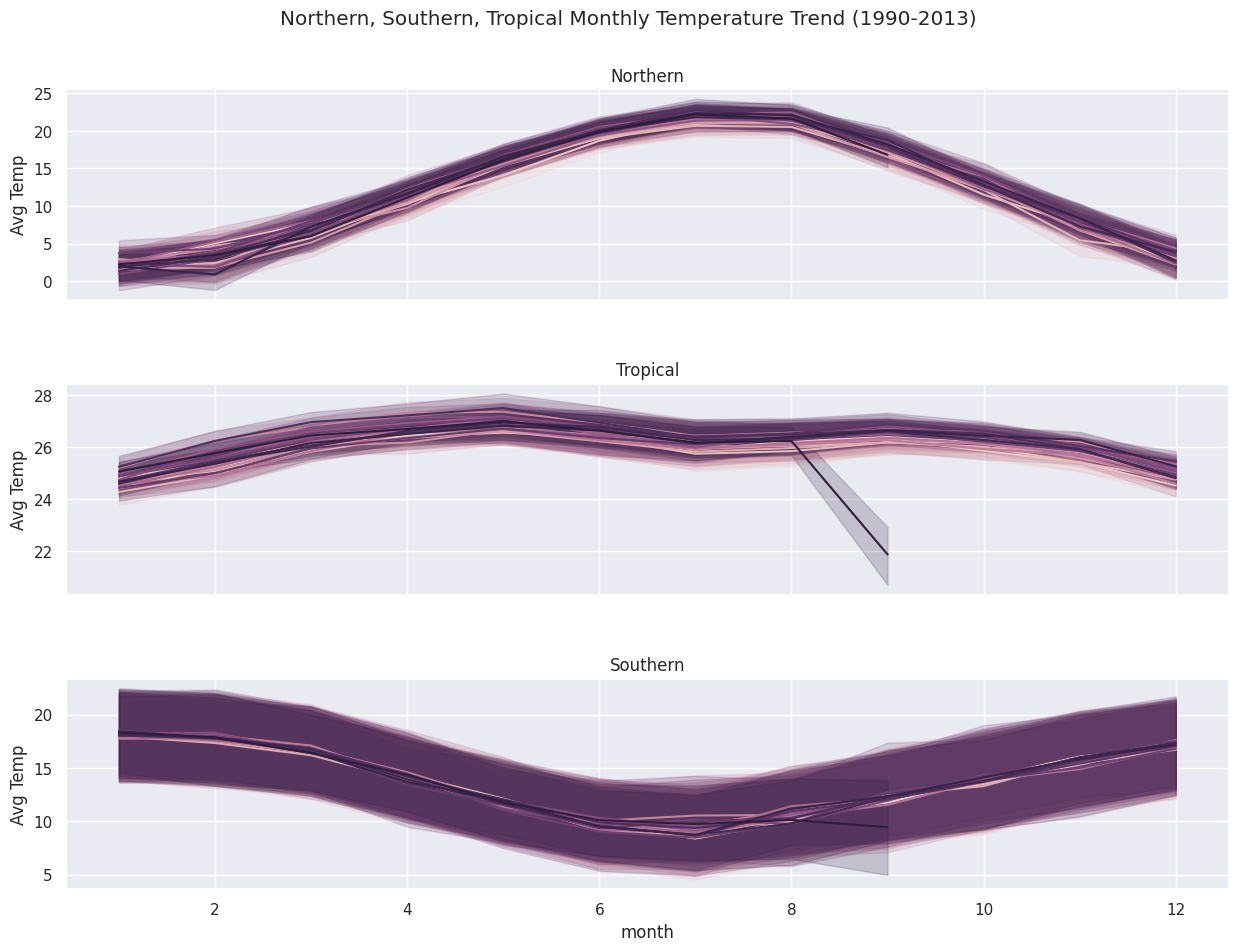

In [ ]:
temp_countries_new = temp_countries.copy()
temp_countries_new.dt = pd.to_datetime(temp_countries_new.dt)
temp_countries_new['year'] = temp_countries_new.dt.dt.year
temp_countries_new['month'] = temp_countries_new.dt.dt.month
temp_countries_tropical = temp_countries_new[temp_countries_new.is_tropical == 1]
temp_countries_northern = temp_countries_new[temp_countries_new.is_northern == 1]
temp_countries_southern = temp_countries_new[temp_countries_new.is_southern == 1]



fig, ax1 = plt.subplots(3,1,figsize=(15, 10), sharex=True)
fig.suptitle("Northern, Southern, Tropical Monthly Temperature Trend (1990-2013)")
plt.subplots_adjust(bottom=0.1,top=0.9,wspace=0.2,hspace=0.4)

sns.lineplot(data=temp_countries_tropical[temp_countries_tropical.year.between(1990,2013)], x="month", y="avg_temp", hue="year", ax=ax1[1], legend=False).set(title="Tropical",ylabel="Avg Temp")

sns.lineplot(data=temp_countries_northern[temp_countries_northern.year.between(1990,2013)], x="month", y="avg_temp", hue="year", ax=ax1[0], legend=False).set(title="Northern",ylabel="Avg Temp")

sns.lineplot(data=temp_countries_southern[temp_countries_southern.year.between(1990,2013)], x="month", y="avg_temp", hue="year", ax=ax1[2], legend=False).set(title="Southern",ylabel="Avg Temp")

plt.show()

In [ ]:
count_disasters = geo_disasters_clean.groupby("country")[["disastertype"]].count().reset_index().rename(columns={"country": "count"})

count_disasters

count  disastertype
0             Afghanistan           402
1                 Albania           121
2                 Algeria           221
3          American Samoa             3
4                  Angola           173
..                    ...           ...
192               Vietnam           840
193  Virgin Islands; U.S.             8
194                 Yemen           100
195                Zambia            75
196              Zimbabwe           114

[197 rows x 2 columns]

### **3.4 Paired T-Test**

#### **Hypothesis: Temperature is Changing**

**Question:** Is there any significant difference in the average temperature from early time period compared to the late period?

* **Null Hypothesis:** There is no significant difference.

* **Alternate Hypothesis:** There is a difference. Therefore, temperature is changing.

USA Data - early from 1931-1971  - late from 1972-2012 (chosen to keep the range consitent)

Chose this range to have consistent number of temp records in both groups


In [ ]:
# for usa

#paired p test between the early temperature from 1930 - 1971 compared to late temperature from 1971 to 2012

# chose this range to have consistent number of temp records in both groups


from scipy import stats
usa_early_temp = united_states_temp[united_states_temp.year.between(1931,1971)]
usa_early_temp = usa_early_temp[['dt','avg_temp']].copy()
usa_late_temp = united_states_temp[united_states_temp.year.between(1972,2012)]
usa_late_temp = usa_late_temp[['dt','avg_temp']].copy()
# print(usa_late_temp.shape)
# print(usa_early_temp.shape)

usa_late_temp = list(usa_late_temp.avg_temp)
usa_early_temp = list(usa_early_temp.avg_temp)

paired_p_result_usa = stats.ttest_rel(usa_early_temp, usa_late_temp)
print("Statistical paired t-test for usa temp data: ",paired_p_result_usa)
print("p-value = %.10f" % paired_p_result_usa.pvalue)


# the p value is less than the 0.05 therefore there is significant difference between the temp in the early years compared to the temp data in the later years
# null hypothesis "there is no difference in the values from the early years and the later years" is rejected.


Statistical paired t-test for usa temp data:  TtestResult(statistic=-6.06668322657948, pvalue=2.6106444504633826e-09, df=491)
p-value = 0.0000000026


The p value is less than the 0.05, we reject the null hypothesis.

Null hypothesis "there is no difference in the values from the early years and the later years" is rejected. Therefore, USA avg temperature has changed compared to previous years.



---



Global Temp data - early from 1930-1971 - late from  1972-2013 (chosen to keep the range consitent)

In [ ]:
#global

temp_global_clean_limited2 = temp_global_clean[temp_global_clean.year.between(1930, 2013)].copy()
temp_global_clean_limited2 = temp_global_clean_limited2.groupby("year").mean().reset_index()

temp_global_clean_limited2

global_early = temp_global_clean_limited2[temp_global_clean_limited2.year.between(1930,1971)]
global_late = temp_global_clean_limited2[temp_global_clean_limited2.year.between(1972,2013)]

# print(global_early.shape)
# print(global_late.shape)

global_early_temp = list(global_early.LandAndOceanAverageTemperature)
global_late_temp = list(global_late.LandAndOceanAverageTemperature)

paired_p_result_global = stats.ttest_rel(global_early_temp,global_late_temp)
print("Statistical paired t-test for global temp data: ",paired_p_result_global)
print("p-value = %.10f" % paired_p_result_global.pvalue)


# the p value is less than the 0.05 therefore there is significant difference between the temp in the early years compared to the temp data in the later years
# null hypothesis "there is no difference in the values from the early years and the later years" is rejected.

Statistical paired t-test for global temp data:  TtestResult(statistic=-9.016766026261084, pvalue=2.7943677733554206e-11, df=41)
p-value = 0.0000000000




The p value is less than the 0.05, we reject the null hypothesis.

Null hypothesis "there is no difference in the values from the early years and the later years" is rejected. Therefore, global avg temperature has changed compared to previous years.


# **4.0 Analysis: ARIMA Model**

ARIMA is often useful for time series analysis, which is an important component of our subject matter. As we explore the temperature trend and the disaster count over the years, our goal is to predict how the disaster count and temperature forecast will look like in future based on current data.

For the analysis, we will use the USA monthly temperature data, Global yearly temperature data, and Global yearly disaster data to create our models. We will use the ADF statistics test to verify if our data is stationary. If the data is not stationary, we will incorporate a difference parameter to our dataset.

## **4.1 ARIMA Model for yearly USA temperature data**

In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 23.7 MB/s eta 0:00:00


In [ ]:
print(temp_global_clean_limited.columns)
print(united_states_temp.columns)
united_states_temp_arima = united_states_temp[['dt', 'avg_temp']].copy()
united_states_temp_arima = united_states_temp_arima.set_index('dt')

united_states_temp_arima.shape[0]

Index(['year', 'LandAndOceanAverageTemperature',
       'LandAndOceanAverageTemperatureUncertainty', 'LandAverageTemperature'],
      dtype='object')
Index(['dt', 'avg_temp', 'country', 'latitude', 'longitude', 'is_tropical',
       'is_northern', 'is_southern', 'month', 'year'],
      dtype='object')


1365

### **4.1.1** Train on USA Temp Data

To choose a good ARIMA model, we utilized the pmdarima library that has an auto_arima function to decide the pdq parameters

In [ ]:
#perform auto arima to get the best pdq values for the lowest error or AIC value

import pmdarima as pm

model = pm.auto_arima(united_states_temp_arima.avg_temp, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, max_d=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
print(model.summary())


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=7218.932, Time=0.83 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=10797.785, Time=0.23 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8078.774, Time=0.51 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=9184.292, Time=0.91 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=6367.892, Time=0.89 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=6375.046, Time=0.71 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=6371.732, Time=1.37 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=6093.170, Time=0.87 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=6722.954, Time=1.22 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=4521.125, Time=4.20 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=4188.462, Time=5.73 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=5992.926, Time=2.73 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=4188.506, Time=9.15 sec

Best model:  ARIMA(3,0,3)(0,0,0)[0]          
Total fit time: 29.464 seconds
                    

We will check the model summary to ensure p values are not significant.

In [ ]:
# running the ARIMA on USA_TEMP_DATA
# seeing the model summary

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from pmdarima import model_selection

train, test = model_selection.train_test_split(united_states_temp_arima, train_size=(round(united_states_temp_arima.shape[0]*0.80)))

model= ARIMA(train, order=(3,0,3))
fit_model = model.fit()

print(fit_model.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:               avg_temp   No. Observations:                 1092
Model:                 ARIMA(3, 0, 3)   Log Likelihood               -1615.565
Date:                Sun, 30 Apr 2023   AIC                           3247.130
Time:                        02:20:43   BIC                           3287.096
Sample:                    01-01-1900   HQIC                          3262.254
                         - 12-01-1990                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.8049      0.038    230.266      0.000       8.730       8.880
ar.L1          0.7343      0.039     18.626      0.000       0.657       0.812
ar.L2          0.7280      0.068     10.660      0.0

Using the plot diagnostics we can see any deviation in fitted models. There are not any outliers and the histogram distribution is even.

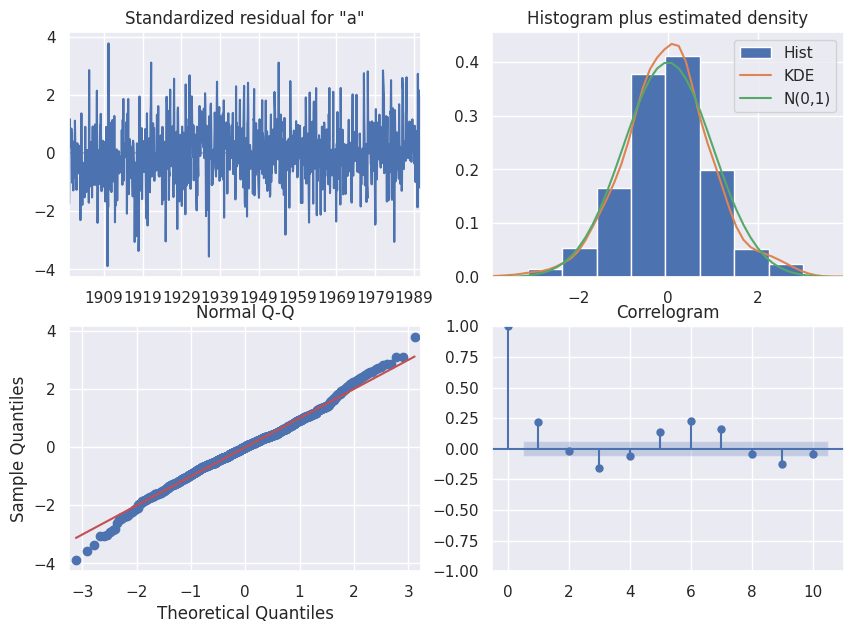

In [ ]:
# ploting the residual and checking for any significant pattern that will show error/bias in model
fit_model.plot_diagnostics(figsize=(10,7))
plt.show()

Plotting the fitted values from the model agains the original data shows that the model is able to adapt to the trends in the dataset.

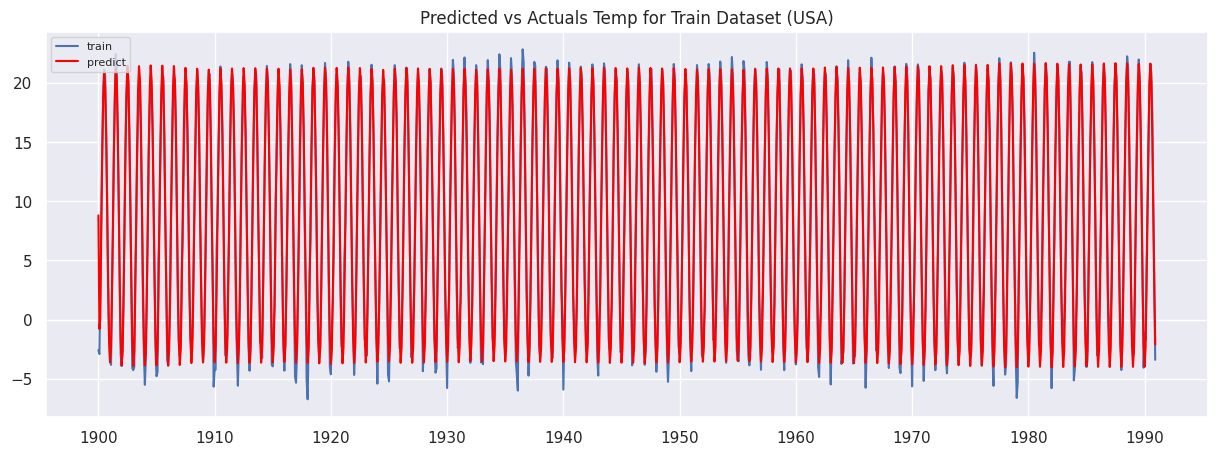

In [ ]:
#plot the train and model data

plt.figure(figsize=(15,5))
plt.plot(train, label='train')
plt.plot(fit_model.fittedvalues,color='red', label='predict')
plt.title('Predicted vs Actuals Temp for Train Dataset (USA)')
plt.legend(loc='upper left', fontsize=8)

### **4.1.2** Test on USA Temp Data

We will run the model against the test dataset range and make our prediction. The plot shows that model is replicating the test values with some bias.

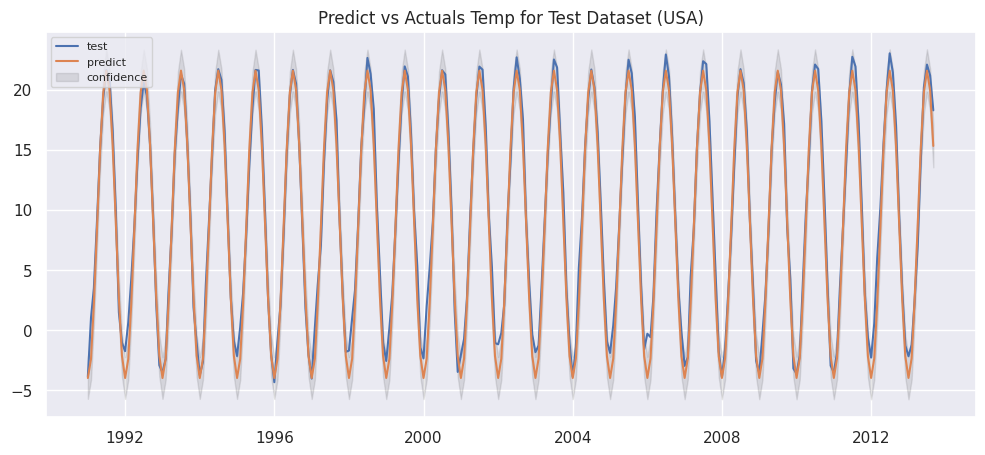

In [ ]:
#making prediction on the test data


#forecast

forecast_result = fit_model.get_forecast(steps=len(test.index), alpha=0.05)

summary_arima = forecast_result.summary_frame(alpha=0.10) #confidence of 90%

#convert results to pandas series
fc = pd.Series(summary_arima['mean'], index=test.index)
lower_interval = pd.Series(summary_arima['mean_ci_lower'], index=test.index)
upper_interval = pd.Series(summary_arima['mean_ci_upper'], index=test.index)


plt.figure(figsize=(12,5), dpi=100)

plt.plot(test, label="test")
plt.plot(fc, label="predict")
plt.fill_between(lower_interval.index, lower_interval, upper_interval,
                 color='k', alpha=.10, label='confidence')
plt.title('Predict vs Actuals Temp for Test Dataset (USA)')
plt.legend(loc='upper left', fontsize=8)


Mean Squared Error of our prediction

In [ ]:
mse= ((fc - pd.Series(test.avg_temp, index=test.index)) ** 2).mean()
mse

1.7043194764674952

### **4.1.3** Predict future Temp Values

We used our model to predict the temperature trend for the next 20 plus years. It seems to show similar trend as previous year but winter maybe getting slightly more colder.

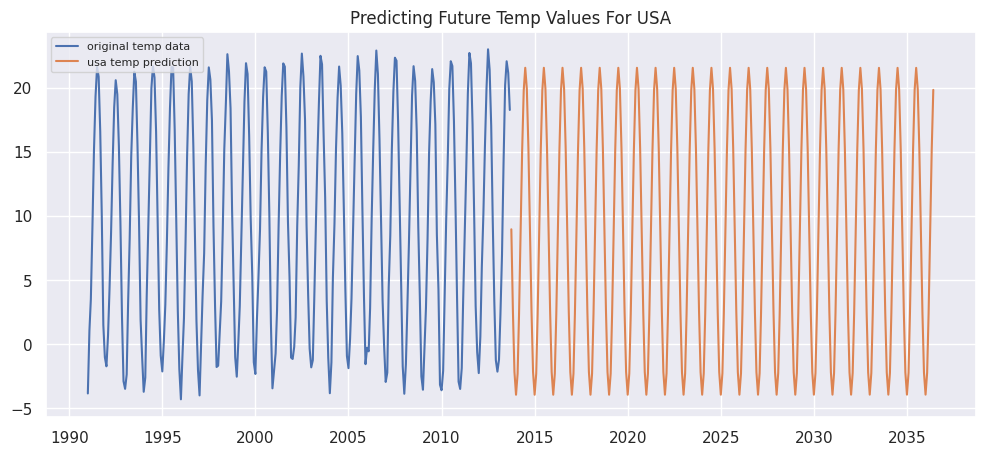

In [ ]:
#projecting into the future

futureRange = len(test.index)*2
forecast_future = fit_model.get_forecast(steps = futureRange)
future_results = forecast_future.summary_frame()
future_temp = future_results['mean']


plt.figure(figsize=(12,5), dpi=100)

plt.plot(test, label="original temp data")
plt.plot(future_temp[len(test.index):], label="usa temp prediction")
# plt.fill_between(lower_interval.index, lower_interval, upper_interval,
#                  color='k', alpha=.10, label='confidence')
plt.title('Predicting Future Temp Values For USA')
plt.legend(loc='upper left', fontsize=8)

## **4.2** ARIMA Model for yearly global temperature data

We will create a new model to predict the temperature trend for the global yearly data and incorporate it with the disaster prediction.  

In [ ]:

#data_US is global temp data # keeping variable as it is being used at many places
temp_global_clean.head()

data_US = temp_global_clean[['year', 'LandAndOceanAverageTemperature']].groupby(by='year').mean().reset_index()
data_US = data_US.rename(columns={'LandAndOceanAverageTemperature': 'avg_temp'})
data_US = data_US[data_US.year.between(1900,2013)].copy()
year  = pd.date_range(start="1900", end="2014", freq="A")
data_US = pd.Series(data_US['avg_temp'].values,year)
data_US.tail()

2009-12-31    15.827167
2010-12-31    15.895500
2011-12-31    15.769500
2012-12-31    15.802333
2013-12-31    15.854417
Freq: A-DEC, dtype: float64

In [ ]:
# temp_US = temp_north_america[temp_north_america.country == "United States of America"][['year','avg_temp']].reset_index(drop = True)
# temp_US = temp_US.loc[(temp_US['year'] >= 1960) & (temp_US['year'] <= 2014)]
# year  = pd.date_range(start="1960", end="2014", freq="A")
# data_US = pd.Series(temp_US['avg_temp'].values,year)



Performing the ADF test to check for Stationary.

In [ ]:
# ADF to test Stationary -

from statsmodels.tsa.stattools import adfuller, acf, pacf

dftest = adfuller(data_US,autolag="AIC")

dfoutput = pd.Series(dftest[0:4], index=["Test Stats", "p-value", "Lags", "observations"])
for key, value in dftest[4].items():
    dfoutput[f"Critical Value ({key})"] = value
print("Results of Dickey-Fuller Test:\n")
print(dfoutput)

Results of Dickey-Fuller Test:

Test Stats                0.158594
p-value                   0.969841
Lags                      6.000000
observations            107.000000
Critical Value (1%)      -3.492996
Critical Value (5%)      -2.888955
Critical Value (10%)     -2.581393
dtype: float64


ADF test suggest that the data is non-stationary. Therefore, we will add a difference parameter.

### **4.2.1** Train on Global Temp Data

Running the auto arima to get the best p and q value. We set the d to 1 as the data is non stationary.

In [ ]:
model3 = pm.auto_arima(data_US, start_p=4, start_q=4,
                      max_P=5, max_Q=5, max_d=1,
                      m=1,
                      d=1,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      )
print(model3.summary())

Performing stepwise search to minimize aic
 ARIMA(4,1,4)(0,0,0)[0] intercept   : AIC=-188.552, Time=5.67 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-173.776, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-178.632, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-189.170, Time=0.51 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-175.408, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-194.297, Time=1.61 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-194.056, Time=1.53 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-193.202, Time=1.40 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-194.890, Time=1.51 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-193.729, Time=2.78 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-197.320, Time=3.28 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-194.909, Time=2.40 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-194.759, Time=1.90 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-196.793, Time=0.45 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept

In [ ]:
model2= ARIMA(data_US, order=(1,1,3))
fit_model2 = model2.fit()

Fitting the model. Cavaet: we did not split the data into train/test as we wanted to incorporate all the dataset to train the model. From our experiment, we noticed when limiting the data for traing the predictions were just a flat line. Hence, the model is fitted on entire dataset.

The plot dianostics shows that the values are distributed evenly. We do have some outliers but should not be significant.

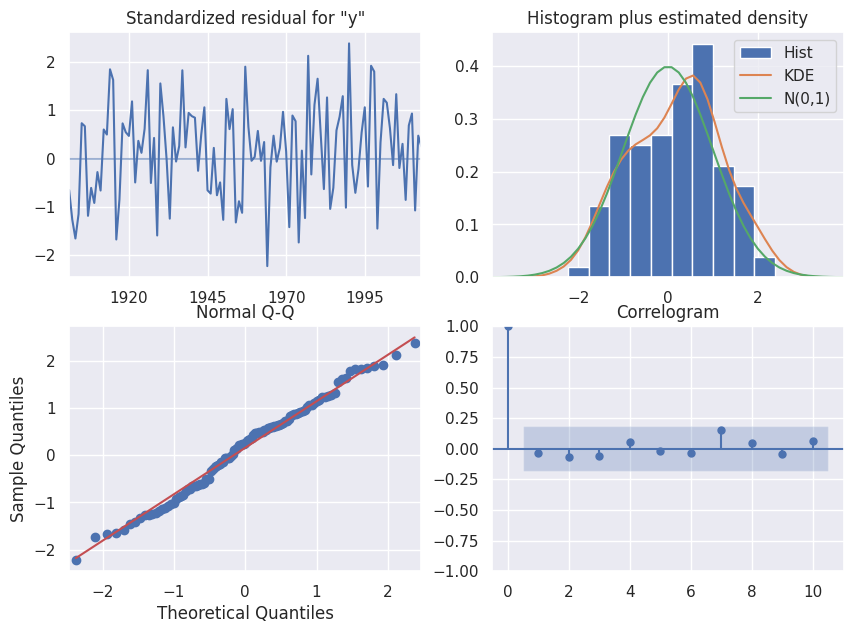

In [ ]:
fit_model2.plot_diagnostics(figsize=(10,7))
plt.show()

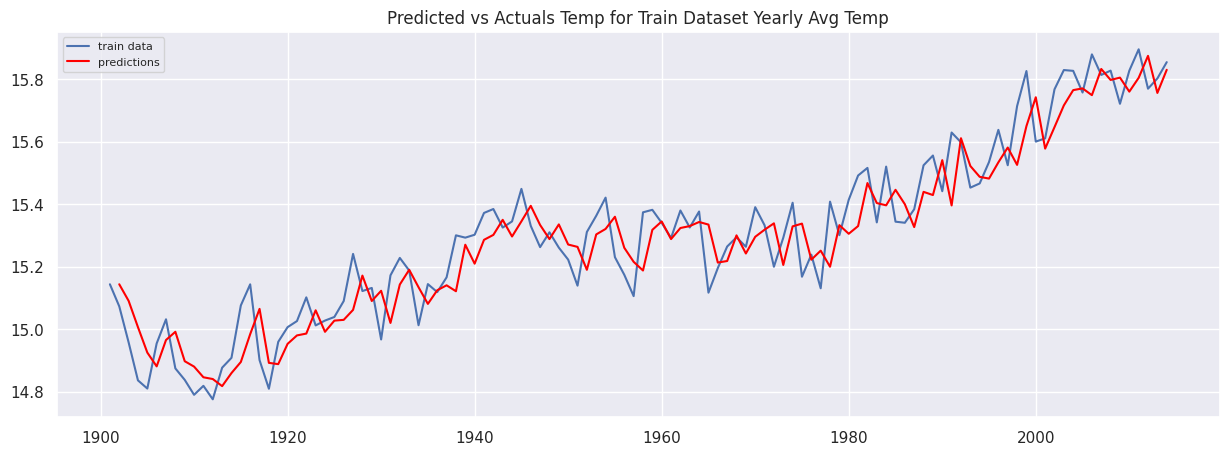

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(data_US, label='train data')
plt.plot(fit_model2.fittedvalues[1:],color='red', label='predictions')#drop 1st fitted value as its insignificant because of shift and difference
plt.title('Predicted vs Actuals Temp for Train Dataset Yearly Avg Temp')
plt.legend(loc='upper left', fontsize=8)

### **4.2.3** Predict future Global Temp values

We will use the model to generate prediction for the next 30 years along with the confidence intervals of 90% to reflect the uncertainity.

The prediction suggests that the temp will remain high at almost an avearge of the last few years.

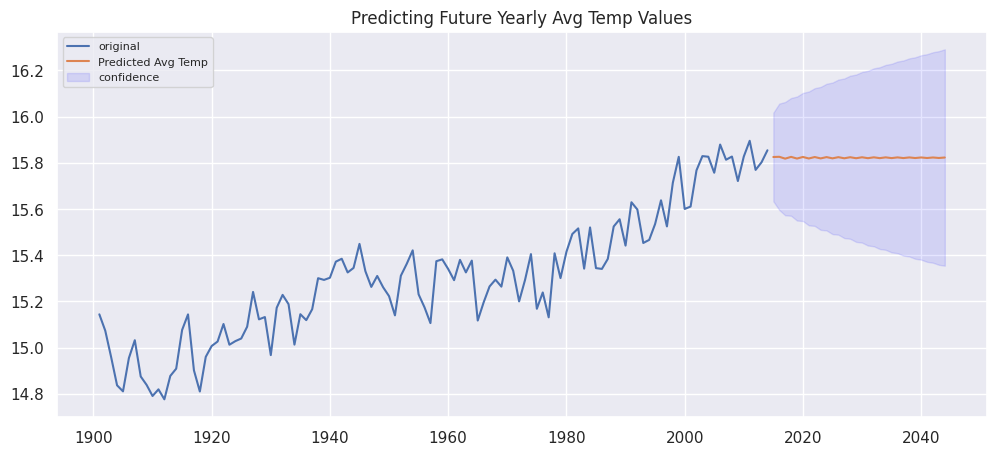

In [ ]:
futureRange = 30
forecast_future = fit_model2.get_forecast(steps = futureRange)
future_results = forecast_future.summary_frame()
future_temp = future_results['mean']


lower_interval_temp = pd.Series(future_results['mean_ci_lower'])
upper_interval_temp = pd.Series(future_results['mean_ci_upper'])


plt.figure(figsize=(12,5))

temp_plot = plt.plot(data_US, label="original")
future_temp_plot = plt.plot(future_temp, label="Predicted Avg Temp")
temp_confidence_plot = plt.fill_between(lower_interval_temp.index, lower_interval_temp, upper_interval_temp,color='blue', alpha=.10, label='confidence')
plt.title('Predicting Future Yearly Avg Temp Values')
plt.legend(loc='upper left', fontsize=8)

## **4.3** ARIMA Model: Disaster Count

The disaster data is setup for time series analysis and an ARIMA model can be used to make a future prediction for disaster count. We will use auto arima to choose p and q parameters.

In [ ]:
# setting up the dataframe for disaster count

count_disasters_yearly = geo_disasters_clean.groupby("year")[["disastertype"]].count().rename(columns={"disastertype": "count"})
count_disasters_yearly.index = pd.to_datetime(count_disasters_yearly.index, format='%Y')
# count_disasters_yearly

The ADF test suggests that the model is non-stationary. We will add d=1 parameter to our model. We will use auto arima for p and q values.

In [ ]:
# ADF test to see stationary


dftest = adfuller(count_disasters_yearly,autolag="AIC")

dfoutput = pd.Series(dftest[0:4], index=["Test Stats", "p-value", "Lags", "observations"])
for key, value in dftest[4].items():
    dfoutput[f"Critical Value ({key})"] = value
print("Results of Dickey-Fuller Test:\n")
print(dfoutput)

print(f"Beacuse the of the p-value of {dfoutput[1]}, the data is non-stationary. We will use difference in model" )

Results of Dickey-Fuller Test:

Test Stats              -1.660916
p-value                  0.451354
Lags                    11.000000
observations            47.000000
Critical Value (1%)     -3.577848
Critical Value (5%)     -2.925338
Critical Value (10%)    -2.600774
dtype: float64
Beacuse the of the p-value of 0.4513537369901777, the data is non-stationary. We will use difference in model


In [ ]:
#running autoarima to see the best model and pick the most suitable one

model_d = pm.auto_arima(count_disasters_yearly, start_p=2, start_q=2,
                         # use adftest to find optimal 'd'
                      max_p=3, max_q=3, max_d=3, # maximum p and q
                      m=1,              # frequency of series
                      d=1,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=1,
                      start_Q=1,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
print(model_d.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=777.464, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=791.506, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=777.868, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=780.406, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=789.788, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=781.560, Time=0.32 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=779.540, Time=0.25 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=785.555, Time=0.52 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=776.465, Time=1.05 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.57 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=779.284, Time=1.05 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=785.554, Time=0.60 sec

Best model:  ARIMA(2,1,3)(0,0,0)[0] intercept
Total fit time: 4.986 seconds
                               SARIMAX Results                                
Dep. Variable:           

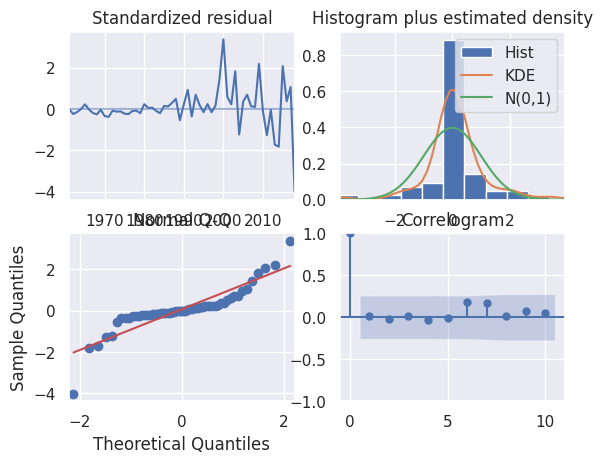

In [ ]:
# to see how the model data is distributed - check even Hist Dist and data points on straight line
model_d.plot_diagnostics()
plt.show()

Splitting the data into train and test set to verify our model

In [ ]:
#ARIMA model for disaster count

#train data and predict the future # run model on test

train_d, test_d = model_selection.train_test_split(count_disasters_yearly, train_size=(round(count_disasters_yearly.shape[0]*0.80)))

model_d= ARIMA(train_d, order=(2,1,2))
fit_model_d = model_d.fit()

print(fit_model_d.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  count   No. Observations:                   47
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -279.312
Date:                Sun, 30 Apr 2023   AIC                            568.624
Time:                        02:22:27   BIC                            577.768
Sample:                    01-01-1960   HQIC                           572.049
                         - 01-01-2006                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7514      0.203     -3.710      0.000      -1.148      -0.354
ar.L2         -0.8080      0.219     -3.686      0.000      -1.238      -0.378
ma.L1          0.4808      1.436      0.335      0.7

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


#### **4.3.1** Train on Disaster Data

Plot the fitted values from the ARIMA model against the original disaster data set.

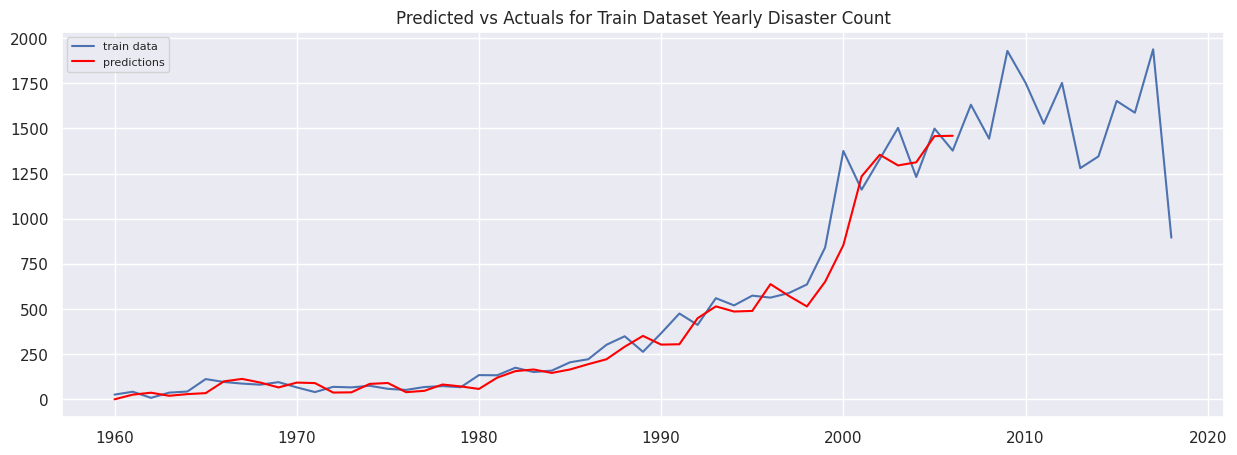

In [ ]:
# train data - model fitted

plt.figure(figsize=(15,5))
plt.plot(count_disasters_yearly, label='train data')
plt.plot(fit_model_d.fittedvalues,color='red', label='predictions')
plt.title('Predicted vs Actuals for Train Dataset Yearly Disaster Count')
plt.legend(loc='upper left', fontsize=8)

In [ ]:
# testing something  - dont remove
len(test_d.index)

forecast_result_d = fit_model_d.get_forecast(steps=len(test_d.index), alpha=0.05)

summary_arima_d = forecast_result_d.summary_frame(alpha=0.10) #confidence of 90%
summary_arima_d['mean']

fc_d = pd.Series(summary_arima_d['mean'])
# fc_d.index = test_d.index
fc_d

2007-01-01    1253.412430
2008-01-01    1365.990848
2009-01-01    1381.268206
2010-01-01    1278.821912
2011-01-01    1343.450500
2012-01-01    1377.672129
2013-01-01    1299.737286
2014-01-01    1330.641450
2015-01-01    1370.395828
2016-01-01    1315.554548
2017-01-01    1324.636638
2018-01-01    1362.126613
Freq: AS-JAN, Name: mean, dtype: float64

#### **4.3.2** Test on Disaster Data

Plot the predictions agains the test dataset along with confidence interval.

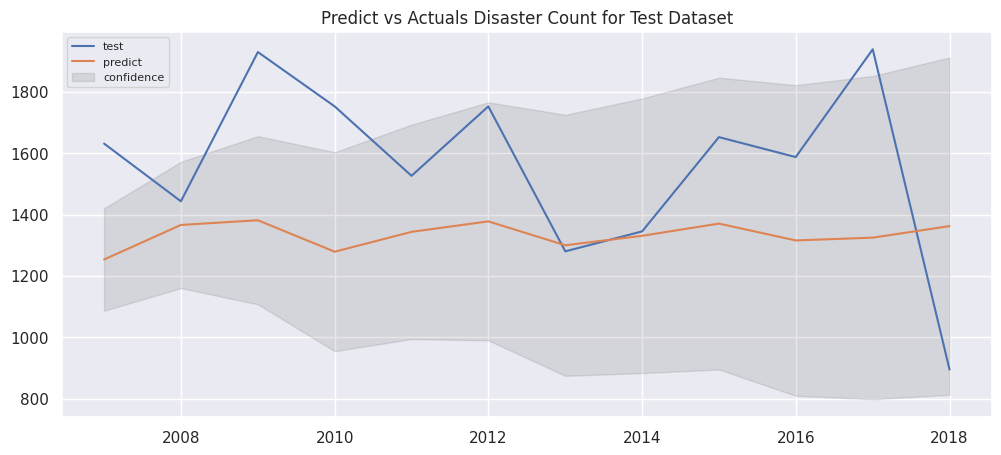

In [ ]:
#making prediction on the test data


#forecast

forecast_result_d = fit_model_d.get_forecast(steps=len(test_d.index), alpha=0.05)

summary_arima_d = forecast_result_d.summary_frame(alpha=0.10) #confidence of 90%

#convert results to pandas series
fc_d = pd.Series(summary_arima_d['mean'])
fc_d.index = test_d.index  #reset index to year

lower_interval_d = pd.Series(summary_arima_d['mean_ci_lower'])
lower_interval_d.index = test_d.index
upper_interval_d = pd.Series(summary_arima_d['mean_ci_upper'])
upper_interval_d.index = test_d.index

plt.figure(figsize=(12,5), dpi=100)

plt.plot(test_d, label="test")
plt.plot(fc_d, label="predict")
plt.fill_between(lower_interval_d.index, lower_interval_d, upper_interval_d, color='k', alpha=.10, label='confidence')
plt.title('Predict vs Actuals Disaster Count for Test Dataset')
plt.legend(loc='upper left', fontsize=8)
plt.show()

#### **4.3.3** Disaster Count Forecast

The model seems to predict that the future disaster count will revolve around the average disaster count of the later years.

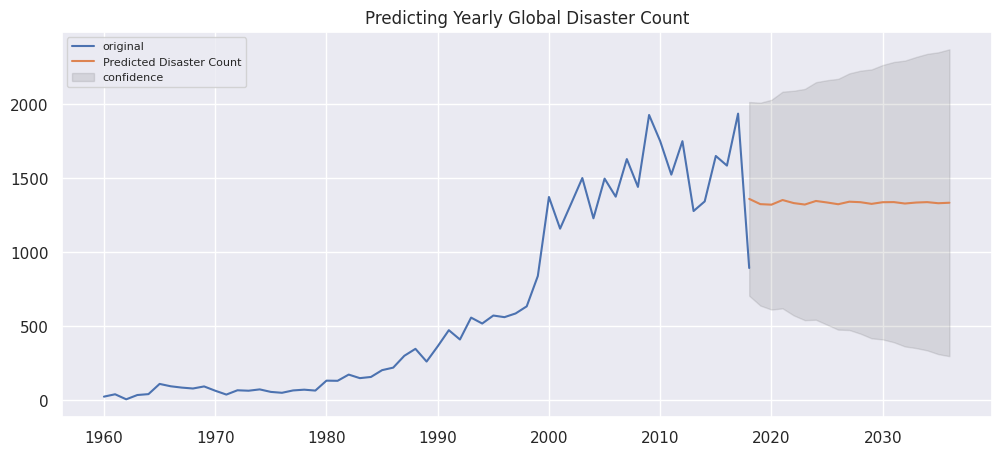

In [ ]:
#predicting into the future

futureRange = 30
forecast_future = fit_model_d.get_forecast(steps=futureRange)
future_results = forecast_future.summary_frame()
future_count = future_results['mean']

lower_interval_fc = pd.Series(future_results['mean_ci_lower'])
# lower_interval_fc.index = test_d.index
upper_interval_fc = pd.Series(future_results['mean_ci_upper'])
# upper_interval_fc.index = test_d.index


plt.figure(figsize=(12,5))

count_dis_plot = plt.plot(count_disasters_yearly, label="original")
future_dis_plot = plt.plot(future_count[len(test_d)-1:], label="Predicted Disaster Count")
dist_confidence = plt.fill_between(lower_interval_fc.index[len(test_d)-1:], lower_interval_fc[len(test_d)-1:], upper_interval_fc[len(test_d)-1:], color='k', alpha=.10, label='confidence')
plt.title('Predicting Yearly Global Disaster Count')
plt.legend(loc='upper left', fontsize=8)

##4.4 Forecasting Yearly Temp and Disaster Trend together



Our goal is to explore the trend in our temp data and disaster data. It will be interesting to incorporate the prediciton for both dataset into one plot and visualize any patterns.

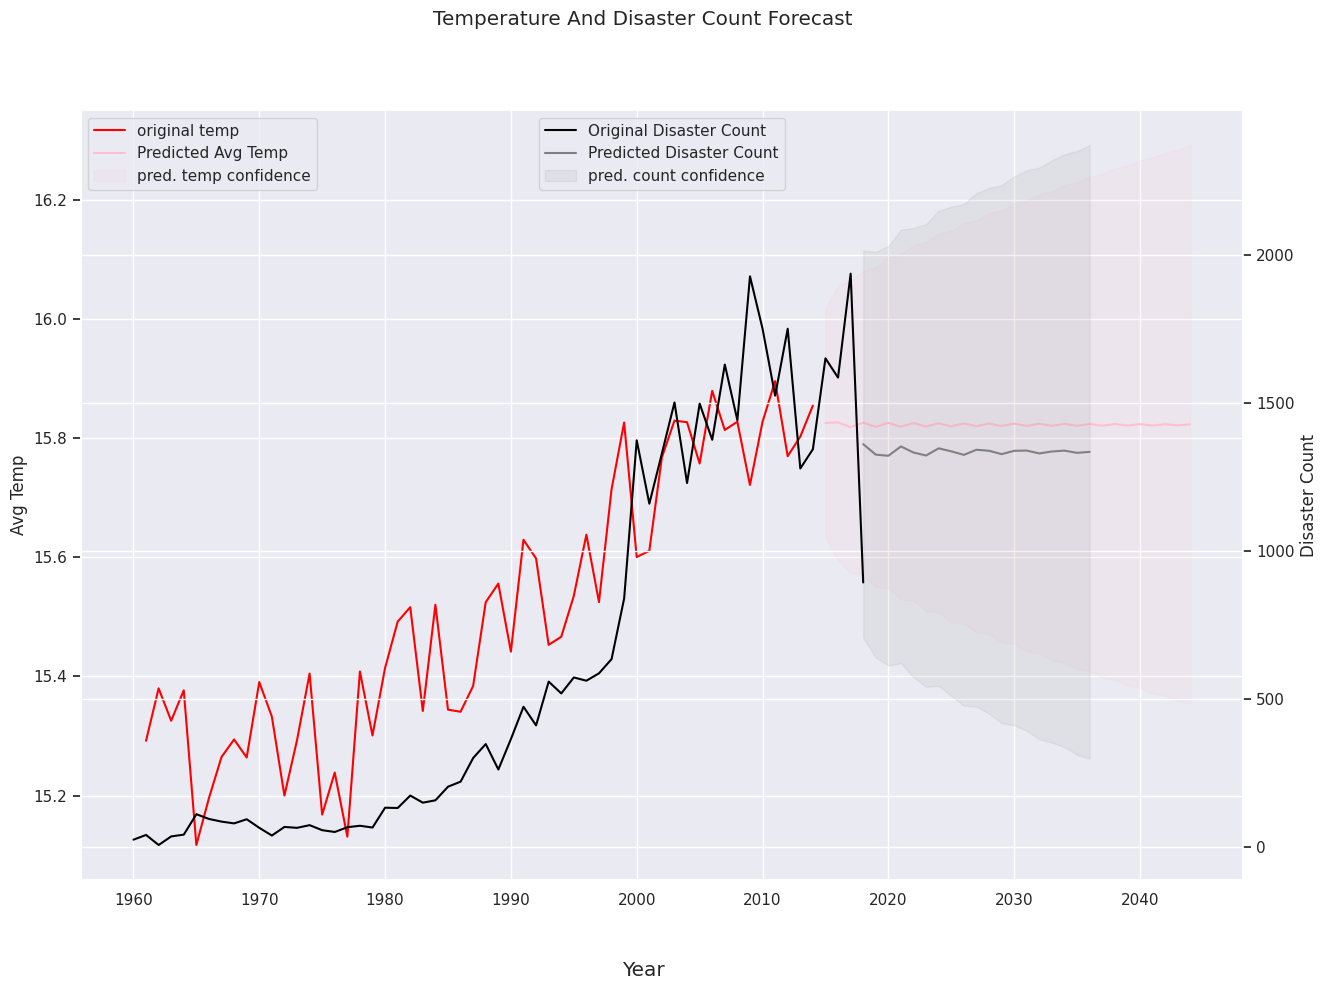

In [ ]:
# Combined Prediciton for Temp And Disaster


# convert to series for plotting
disaster_count = count_disasters_yearly.squeeze()
disaster_count

fig, predict_plot = plt.subplots(sharey=False, figsize=(15,10))
plot_2 =predict_plot.twinx()
fig.suptitle("Temperature And Disaster Count Forecast")
fig.supxlabel("Year")

sns.lineplot(data_US['1960-01-01':], label="original temp", ax=predict_plot, color='red')
sns.lineplot(future_temp, label="Predicted Avg Temp", ax=predict_plot, color='pink')

predict_plot.fill_between(lower_interval_temp.index, lower_interval_temp, upper_interval_temp,color='pink', alpha=.10, label='pred. temp confidence')
predict_plot.legend(loc='upper left')
predict_plot.set_ylabel('Avg Temp')

dx = sns.lineplot(disaster_count, ax=plot_2, color='black', label='Original Disaster Count')

sns.lineplot(future_count[len(test_d)-1:], label="Predicted Disaster Count", color='grey', ax=plot_2)

plot_2.fill_between(lower_interval_fc.index[len(test_d)-1:], lower_interval_fc[len(test_d)-1:], upper_interval_fc[len(test_d)-1:], color='grey', alpha=.10, label='pred. count confidence')
plot_2.legend(loc='upper center')
plot_2.set_ylabel('Disaster Count')
plt.show()

Based on the ARIMA model prediction, the avg temperature and the disaster count have gone up compared to previous years.

# **5.0** Analysis: Exponential Smoothing of Temperature Data



In [ ]:
US_geo = geo_disasters_clean[geo_disasters_clean.country == 'United States of America']
US_geo = US_geo[US_geo.year.isin(range(1990,2014))]
US_geo = US_geo.groupby("year")[["disastertype"]].count().reset_index().rename(columns={"country": "count"})
US_geo

Empty DataFrame
Columns: [year, disastertype]
Index: []

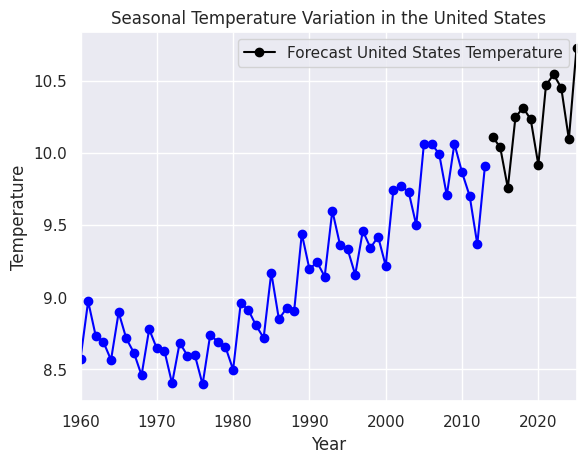

In [ ]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt


temp_US = temp_north_america[temp_north_america.country == "United States of America"][['year','avg_temp']].reset_index(drop = True)
temp_US = temp_US.loc[(temp_US['year'] >= 1960) & (temp_US['year'] <= 2014)]
year  = pd.date_range(start="1960", end="2014", freq="A")
data_US = pd.Series(temp_US['avg_temp'].values,year)

fit1 = ExponentialSmoothing(data_US, seasonal_periods=4, trend='add', seasonal='add', use_boxcox=True, initialization_method="estimated").fit()
fcast1 = fit1.forecast(12).rename("Forecast United States Temperature")

fit1.fittedvalues.plot(marker="o", color='blue')
fcast1.plot(color='black', marker="o", legend=True)

plt.xlabel("Year")
plt.ylabel("Temperature")
plt.title("Seasonal Temperature Variation in the United States")
plt.show()

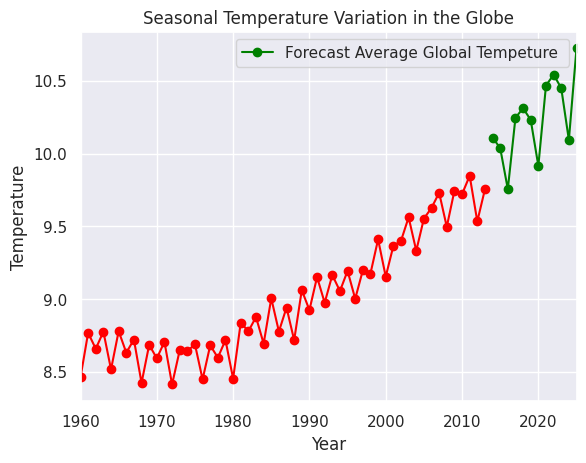

In [ ]:
temp_global_clean_a = temp_global_clean[temp_global_clean.year.between(1960, 2013)].copy()
temp_global_clean_a = temp_global_clean_a.groupby("year").mean().reset_index()
temp_global_clean_a = temp_global_clean_a[["year","LandAverageTemperature"]]
temp_global_clean_a
year  = pd.date_range(start="1960", end="2014", freq="A")
data_temp_global = pd.Series(temp_global_clean_a['LandAverageTemperature'].values,year)

fit2 = ExponentialSmoothing(data_temp_global, seasonal_periods=4, trend='add', seasonal='add', use_boxcox=True, initialization_method="estimated").fit()
fcast2 = fit1.forecast(12).rename("Forecast Average Global Tempeture ")

fcast2.plot(marker='o', color='green', legend=True)
fit2.fittedvalues.plot(marker='o', color='red')

plt.xlabel("Year")
plt.ylabel("Temperature")
plt.title("Seasonal Temperature Variation in the Globe")
plt.show()

# *6.0* Analysis: Random Forest

Use Random Forest Classifier to study the impact of rising temperatures on the frequency of floods.

1. Prepare the data for modeling, creating our classes/label dataset separate from our prediction, floods.  Our classes include: year, average temp, and precipitation to predict which locations will be impacted by floods.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
#train_df = temp_countries_yearly2.drop(columns = ['country','country_code','year','precipitation_days_year','precipitation_mm_year'])
train_df = temp_countries_yearly2.drop(columns = ['latitude','longitude','is_tropical','is_northern','is_southern','country','country_code'])

y_batch = train_df.iloc[:,2].to_numpy()
train_df = train_df.drop(columns = ['flood_count'])
y_batch = y_batch[:, None]
train_df = train_df.iloc[:, :-1]
x_batch = train_df.to_numpy()

#min max scale the features
sc = MinMaxScaler()
x_batch=sc.fit_transform(x_batch)

print("Features shape {}".format(x_batch.shape))
print("Label shape {}".format(y_batch.shape))



Features shape (26296, 3)
Label shape (26296, 1)


2. Split the training data and testing data,
70% of the data for training, 30% of the data for testing.

In [ ]:
import torch
import torch.nn as fnn
import torch.optim as optim
X_train, X_test, y_train, y_test = train_test_split(x_batch, y_batch, test_size=0.3, random_state=42)

#convert to tensors
X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(y_train)
X_test = torch.from_numpy(X_test)
y_test = torch.from_numpy(y_test)

# check the training tensor and testing tensor size
print("Training Data: features :{},  label:{}".format(X_train.shape, y_train.shape))
print("Testing Data: features :{},  label :{}".format(X_test.shape, y_test.shape))


Training Data: features :torch.Size([18407, 3]),  label:torch.Size([18407, 1])
Testing Data: features :torch.Size([7889, 3]),  label :torch.Size([7889, 1])


3.  Make a prediction, and test precision, recall and accuracy values.  Accuracy, precision, and recall are all high, which further validates the correlation of the model

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
filled_X_train = tf.where(tf.math.is_finite(X_train), X_train, tf.constant(0.0))
filled_X_test = tf.where(tf.math.is_finite(X_test), X_test, tf.constant(0.0))
model = RandomForestClassifier(random_state=42)
model.fit(filled_X_train, y_train)
y_pred = model.predict(filled_X_test)
precision = precision_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')
accuracy = accuracy_score(y_test, y_pred)


<ipython-input-151-1e9708fc317a>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(filled_X_train, y_train)


In [ ]:
print("precision {:.2f}, recall {:.2f}, accuracy {:.2f}".format(precision, recall, accuracy))


precision 0.92, recall 0.92, accuracy 0.92


#7.0 Conclusions



## **7.1** Obstacles and Challenges


The data was more challenging to work with than anticipated.
* The temperature data was tracked by country name, city name, and coordinates.  But without ISO-standard country codes, it required considerable data wrangling to connect this data with other data at the country level.
* The quantity of disaster data is fairly limited.  When tracking across country and year, it becomes particularly sparse for the purposes of forecasting.
* When we began the project, we hoped to gain insight into the distribution of disasters by city.  When the lack of data prevented that, we hoped we could do so by country.  That also was not ideal, so we reverted to doing mostly global analysis.

## **7.2** Conclusions from EDA and Models

There seems to be a strong correlation at the global level between rising temperatures and an increase in natural disasters.  Beyond the descriptive/exploratory techniques thta seemed to visually confirm the correlation, the ARIMA model also seemed to confirm it as well. The Exponential Smoothing model of the temperature data confirmed the prediction of rising temps, and the Random Forest Classifier seemed to have high confidence in predicting flood disasters based on the temperature, year, and precipitation data.

One interesting observation is that both the northern and tropical zones (the combined area north of the Tropic of Capricorn) seem to each be much more affected by both temperature changes and disasters than the the southern zone (below the Tropic of Capricorn).

##**7.3** Next Steps

Given the limitations of the disaster data (low quantity), it might be more interesting to look at precursors to disasters to have more data to work with:
* lower than average rainful (droughts)
* higher than average rainful (mudslides, floods)
* storm quantity and intensity
* the temperature range for "deadly" heatwaves